In [50]:
%matplotlib inline
import matplotlib as mpl
import cartopy.feature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.ticker import AutoMinorLocator, LogLocator
import matplotlib.gridspec as gridspec
import matplotlib.mlab as mlab
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import numpy as np
import pandas as pd
import xarray as xr
import SCM6
import scipy.fft as fft
import scipy.signal as signal
import scipy.ndimage as ndimage
from scipy import stats
import cftime
import datetime

# pylaeoclim_leeds v0.0
import pylaeoclim_leeds.hadcm3_processing as hcm3
import pylaeoclim_leeds.zones as zones
import pylaeoclim_leeds.plots as plots
import pylaeoclim_leeds.util_hadcm3 as util

# mw_protocol v0.0
import mw_protocol.plotting as plotting
import mw_protocol.spreading as spreading
import mw_protocol.glac1d_toolbox as tb

# Millennial-scale climate oscillations triggered by deglacial meltwater discharge in last glacial maximum simulations

**Abstract** : Our limited understanding of millennial-scale variability in the context of the last glacial period can be explained by the lack of a reliable modelling framework to study abrupt climate changes under realistic glacial backgrounds. In this article, we describe a new set of long-run Last Glacial Maximum experiments where such climate shifts were triggered by different snapshots of ice-sheet meltwater derived from the early stages of the last deglaciation. Depending on the location and the magnitude of the forcing, we observe three distinct dynamical regimes and highlight a subtle window of opportunity where the climate can sustain oscillations between cold and warm modes. We identify the European-Arctic and Nordic Seas regions as being most sensitive to meltwater discharge in the context of switching to a cold mode, compared to freshwater fluxes from the Laurentide ice sheets. These cold climates follow a consistent pattern in temperature, sea ice and convection, and are largely independent from freshwater release as a result of effective AMOC collapse. Warm modes, on the other hand, show more complexity in their response to the regional pattern of the meltwater input, and within them, we observe significant changes linked to the reorganisation of deep water formation sites and the subpolar gyre. Broadly, the main characteristics of the oscillations, obtained under full-glacial conditions with realistically low meltwater discharge, are comparable to $\delta^{18}O$ records of the last glacial period, although our simplified experiment design prevents detailed conclusions from being drawn on whether these represent actual Dansgaard-Oeschger events.

## Variables

In [55]:
expts = ['xoupa', 'xoupd', 'xouph', 'tfgbi', 'xoupl', 'xoupf', 'tfgbj']
colors = {'xoupa':'black', 'tfgbd':'xkcd:royal blue', 'xoupd':'xkcd:royal blue', 'xouph':'maroon', 'tfgbi':'xkcd:rose', 'tfgbr':'xkcd:grass green', 'xoupl':'xkcd:grass green', 'xoupf':'xkcd:dark orange', 'tfgbj':'xkcd:light orange'}
colors_cold = {'xoupd':plots.scale_lightness('xkcd:royal blue', 0.7), 'xouph':plots.scale_lightness('xkcd:maroon', 0.8), 'tfgbi':plots.scale_lightness('xkcd:rose', 0.7), 'xoupl':plots.scale_lightness('xkcd:grass green', 0.9), 'xoupf':plots.scale_lightness('xkcd:dark orange', 0.9), 'tfgbj':plots.scale_lightness('xkcd:light orange', 0.7)}
colors_warm = {'xoupd':plots.scale_lightness('xkcd:royal blue', 1.2), 'xouph':plots.scale_lightness('xkcd:maroon', 1.05), 'tfgbi':plots.scale_lightness('xkcd:rose', 1.2), 'xoupl':plots.scale_lightness('xkcd:grass green', 1.1), 'xoupf':plots.scale_lightness('xkcd:dark orange', 1.05), 'tfgbj':plots.scale_lightness('xkcd:light orange', 1.2)}
colors_method = {'Method 1':'xkcd:magenta', 'Method 1b':'xkcd:olive green', 'Method 2':'xkcd:mustard', 'Method 3':'xkcd:indigo', 'Method 4':'xkcd:pumpkin', 'Method 5':'xkcd:blue green'}
labels = {'xoupa':'CTRL', 'tfgbd':'21.5k', 'xoupd':'21.5k', 'xouph':'21k', 'tfgbi':'20.7k', 'tfgbr':'19.4k', 'xoupl':'19.4k', 'xoupf':'18.2k', 'tfgbj':'17.8k'}
snapshots = {'tfgbd':21.5, 'xoupd':21.5, 'xouph':21, 'tfgbi':20.7, 'tfgbr':19.4, 'xoupl':19.4, 'xoupf':18.2, 'tfgbj':17.8}
start_dates = {'xoupa':-1000, 'tfgbd':0, 'xoupd':0, 'xouph':0, 'tfgbi':0, 'tfgbr':0, 'xoupl':0, 'xoupf':0, 'tfgbj':0}
smooth_date = {'xoupa':3800, 'xoupd':4060-1000, 'xoupf':9900-1000, 'xouph':3650-1000, 'xoupl':9610-1000}

In [30]:
lon_na_min, lon_na_max, lat_na_min, lat_na_max = 290, 370, 45, 80
zone_na = util.cycle_box(lon_na_min, lon_na_max, lat_na_min, lat_na_max)
box_na = zones.Box(lon_na_min, lon_na_max, lat_na_min, lat_na_max, z_min = -1000)
plane_na = zones.Box(lon_na_min, lon_na_max, lat_na_min, lat_na_max)

lon_esp_min, lon_esp_max, lat_esp_min, lat_esp_max = 335, 350, 45, 55
zone_esp = util.cycle_box(lon_esp_min, lon_esp_max, lat_esp_min, lat_esp_max)
box_esp = zones.Box(lon_esp_min, lon_esp_max, lat_esp_min, lat_esp_max, z_min = -1000)
plane_esp = zones.Box(lon_esp_min, lon_esp_max, lat_esp_min, lat_esp_max)

lon_at_min, lon_at_max, lat_at_min, lat_at_max = 290, 370, -20, 80
zone_at = util.cycle_box(lon_at_min, lon_at_max, lat_at_min, lat_at_max)
box_at = zones.Box(lon_at_min, lon_at_max, lat_at_min, lat_at_max, z_min = -1000)
plane_at = zones.Box(lon_at_min, lon_at_max, lat_at_min, lat_at_max)

## Model boundary conditions and meltwater forcing

### Figure 1 - Bathymerty

In [36]:
ds = xr.open_dataset('/nfs/annie/eeymr/work/data/glac_mw/GLAC1DHiceF26.nc').HGLOBH.sel(
    T122KP1=-21.0, method="nearest", drop="True")

values_hice = np.where(ds.values<50, np.NAN, ds.values)
lon_glac, lat_glac = ds.XLONGLOBP5.values, ds.YLATGLOBP25.values

ds = xr.open_dataset("~/dump2hold/xoupa/pcpd/xoupaa#pd000004000mr+.nc").ht_mm_srf.isel(
    t=0, drop=True).isel(surface=0, drop=True)
values_oro = np.where(ds.values<1, np.NAN, ds.values)
lon_oro, lat_oro = ds.longitude, ds.latitude

ds = xr.open_dataset("/nfs/see-fs-01_users/eeymr/dump2hold/xoupa/pg/xoupao#pg000003000c1+.nc")
values_bathymetry = np.where(util.extract_bathymetry(ds)<11, np.NAN, -util.extract_bathymetry(ds)) # Filtered shallow points
lon_ocn, lat_ocn = ds.longitude, ds.latitude

__ Initialising the norm from vmin and vmax values
__ Initialising the norm from vmin and vmax values


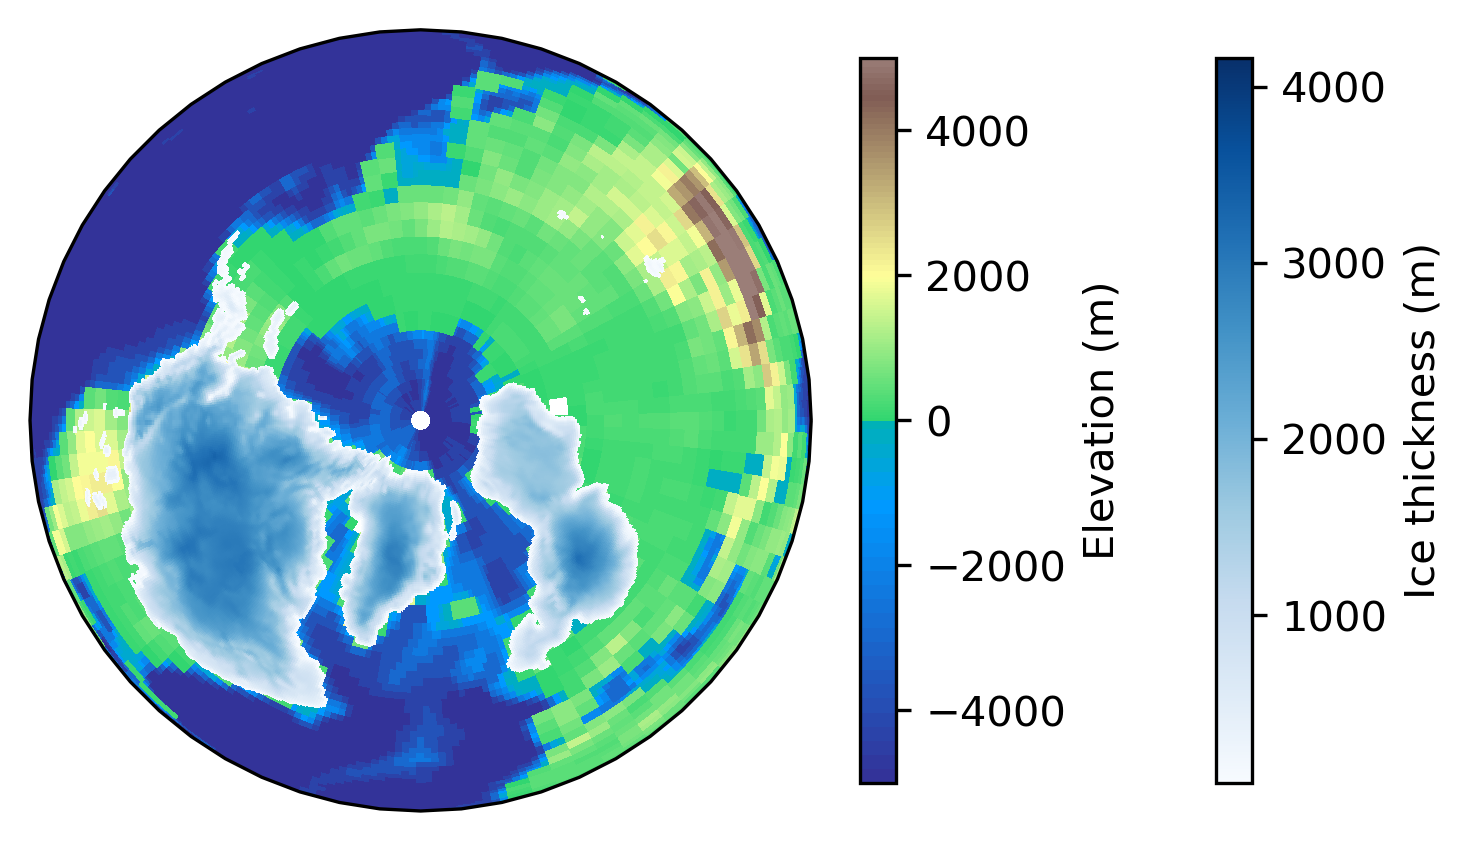

In [38]:
bathymetry = plt.get_cmap('terrain', 128)(np.linspace(0, 0.2, 256))
elevation = plt.get_cmap('terrain', 128)(np.linspace(0.3, 0.8, 256))

newcmp = mpl.colors.ListedColormap(np.vstack((bathymetry, elevation)), name='terrain_centered')
mymap = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', np.vstack((bathymetry, elevation)),)

norm_oro = plots.Normalize(vmin=0, vmax=5000)
norm_ocn = plots.Normalize(vmin=-5000, vmax=0)
norm = mpl.colors.TwoSlopeNorm(vmin=-5000, vcenter=0, vmax=5000)


projection_map = ccrs.NearsidePerspective(central_longitude=-30.0, central_latitude=90.0, satellite_height=30000000)
figMap, axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(6,4), dpi=300)

cb_bathymetry = axMap.pcolormesh(lon_ocn, lat_ocn, values_bathymetry, cmap=mpl.colors.ListedColormap(bathymetry), 
                                 norm=norm_ocn, transform=ccrs.PlateCarree())
cb_oro = axMap.pcolormesh(lon_oro, lat_oro, values_oro, cmap=mpl.colors.ListedColormap(elevation),
                          norm=norm_oro, transform=ccrs.PlateCarree())
cb_ice = axMap.pcolormesh(lon_glac, lat_glac, values_hice, transform=ccrs.PlateCarree(),cmap="Blues")
axMap.set_global()

figMap.colorbar(mappable=cb_ice, ax=axMap, label="Ice thickness (m)", orientation="vertical", shrink = 0.8, pad=0.15)
figMap.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=mymap), ax=axMap, label='Elevation (m)', orientation='vertical', shrink = 0.8)

### Figure X - Meltwater protocol

In [39]:
ds_discharge = xr.open_dataset('/nfs/see-fs-01_users/eeymr/work/outputs/glac_mw/xoup/xoup.wfix.glac_ts.nc',decode_times=False)
ds_lsm = xr.open_dataset('/nfs/annie/earpal/database/experiments/temev/inidata/temev.qrparm.omask.nc')
ds_waterfix = xr.open_dataset("/nfs/annie/eeymr/work/data/glac_mw/qrparm.waterfix.hadcm3.nc")

ts = plotting.create_discharge_ts(ds_discharge, ds_lsm, ds_waterfix, unit="kg/m2/s")
t = ds_discharge.t.values

flux_na = ts['North America']
flux_egi = ts['East Greenland & Iceland']
flux_gin = ts['GIN']
flux_med = ts['Mediterranean']
flux_arc = ts['Arctic']
flux_ss = ts['Southern seas']
flux_pac = ts['Pacific']
flux_tot = ts['Total']

<generator object create_discharge_ts.<locals>.<genexpr> at 0x2b7050ab4ba0>


In [40]:
ds_lsm = xr.open_dataset('/nfs/annie/earpal/database/experiments/temev/inidata/temev.qrparm.omask.nc')
lon_lsm, lat_lsm, depth, lsm = ds_lsm.longitude.values, ds_lsm.latitude.values, ds_lsm.depthdepth.values, ds_lsm.lsm.values
masked = np.copy(lsm)  # land mask True (1) on land
depthm = np.ma.masked_less(depth, 500.0)  # mask areas shallower than 500m
masked_500m = np.copy(depthm.mask) + masked  # create binary mask from depth data
lat, lon = spreading.LatAxis(lat_lsm[:]), spreading.LonAxis(lon_lsm[:])
umgrid = spreading.Grid(lat, lon)

cb = spreading.generate_collection_boxes()
sr = spreading.generate_spreading_regions(cb, umgrid, masked, masked_500m)

In [58]:
ds =  xr.open_dataset("/nfs/see-fs-01_users/eeymr/my_ancil/HadCM3/xoup/xoup.wfix.lgm.nc", decode_times=False)
ds_wfix = xr.open_dataset("/nfs/annie/earpal/database/experiments/temev/inidata/temev.qrparm.waterfix.nc")
wfix = ds_wfix.field672.isel(t=0).isel(depth=0)
lon = ds.longitude.values
lat = ds.latitude.values

mw_215 = xr.open_dataset("/nfs/see-fs-01_users/eeymr/my_ancil/HadCM3/xoup/xoup.wfix.lgm.nc", decode_times=False).field672.isel(t=0).isel(depth=0) - wfix
mw_21 = xr.open_dataset("/nfs/see-fs-01_users/eeymr/my_ancil/HadCM3/xoup/xoup.wfix.lgm1.nc", decode_times=False).field672.isel(t=0).isel(depth=0) - wfix
mw_207 = xr.open_dataset("/nfs/see-fs-01_users/eeymr/my_ancil/HadCM3/xoup/xoup.wfix.lgm2.nc", decode_times=False).field672.isel(t=0).isel(depth=0) - wfix
mw_194 = xr.open_dataset("/nfs/see-fs-01_users/eeymr/my_ancil/HadCM3/xoup/xoup.wfix.lgm_na.nc", decode_times=False).field672.isel(t=0).isel(depth=0) - wfix
mw_182 = xr.open_dataset("/nfs/see-fs-01_users/eeymr/my_ancil/HadCM3/xoup/xoup.wfix.lgm_arc.nc", decode_times=False).field672.isel(t=0).isel(depth=0) - wfix
mw_178 = xr.open_dataset("/nfs/see-fs-01_users/eeymr/my_ancil/HadCM3/xoup/xoup.wfix.lgm_arc2.nc", decode_times=False).field672.isel(t=0).isel(depth=0) - wfix

/nfs/see-fs-01_users/eeymr/.conda/envs/eeymr/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


Text(0.0, 1.0, 'b')

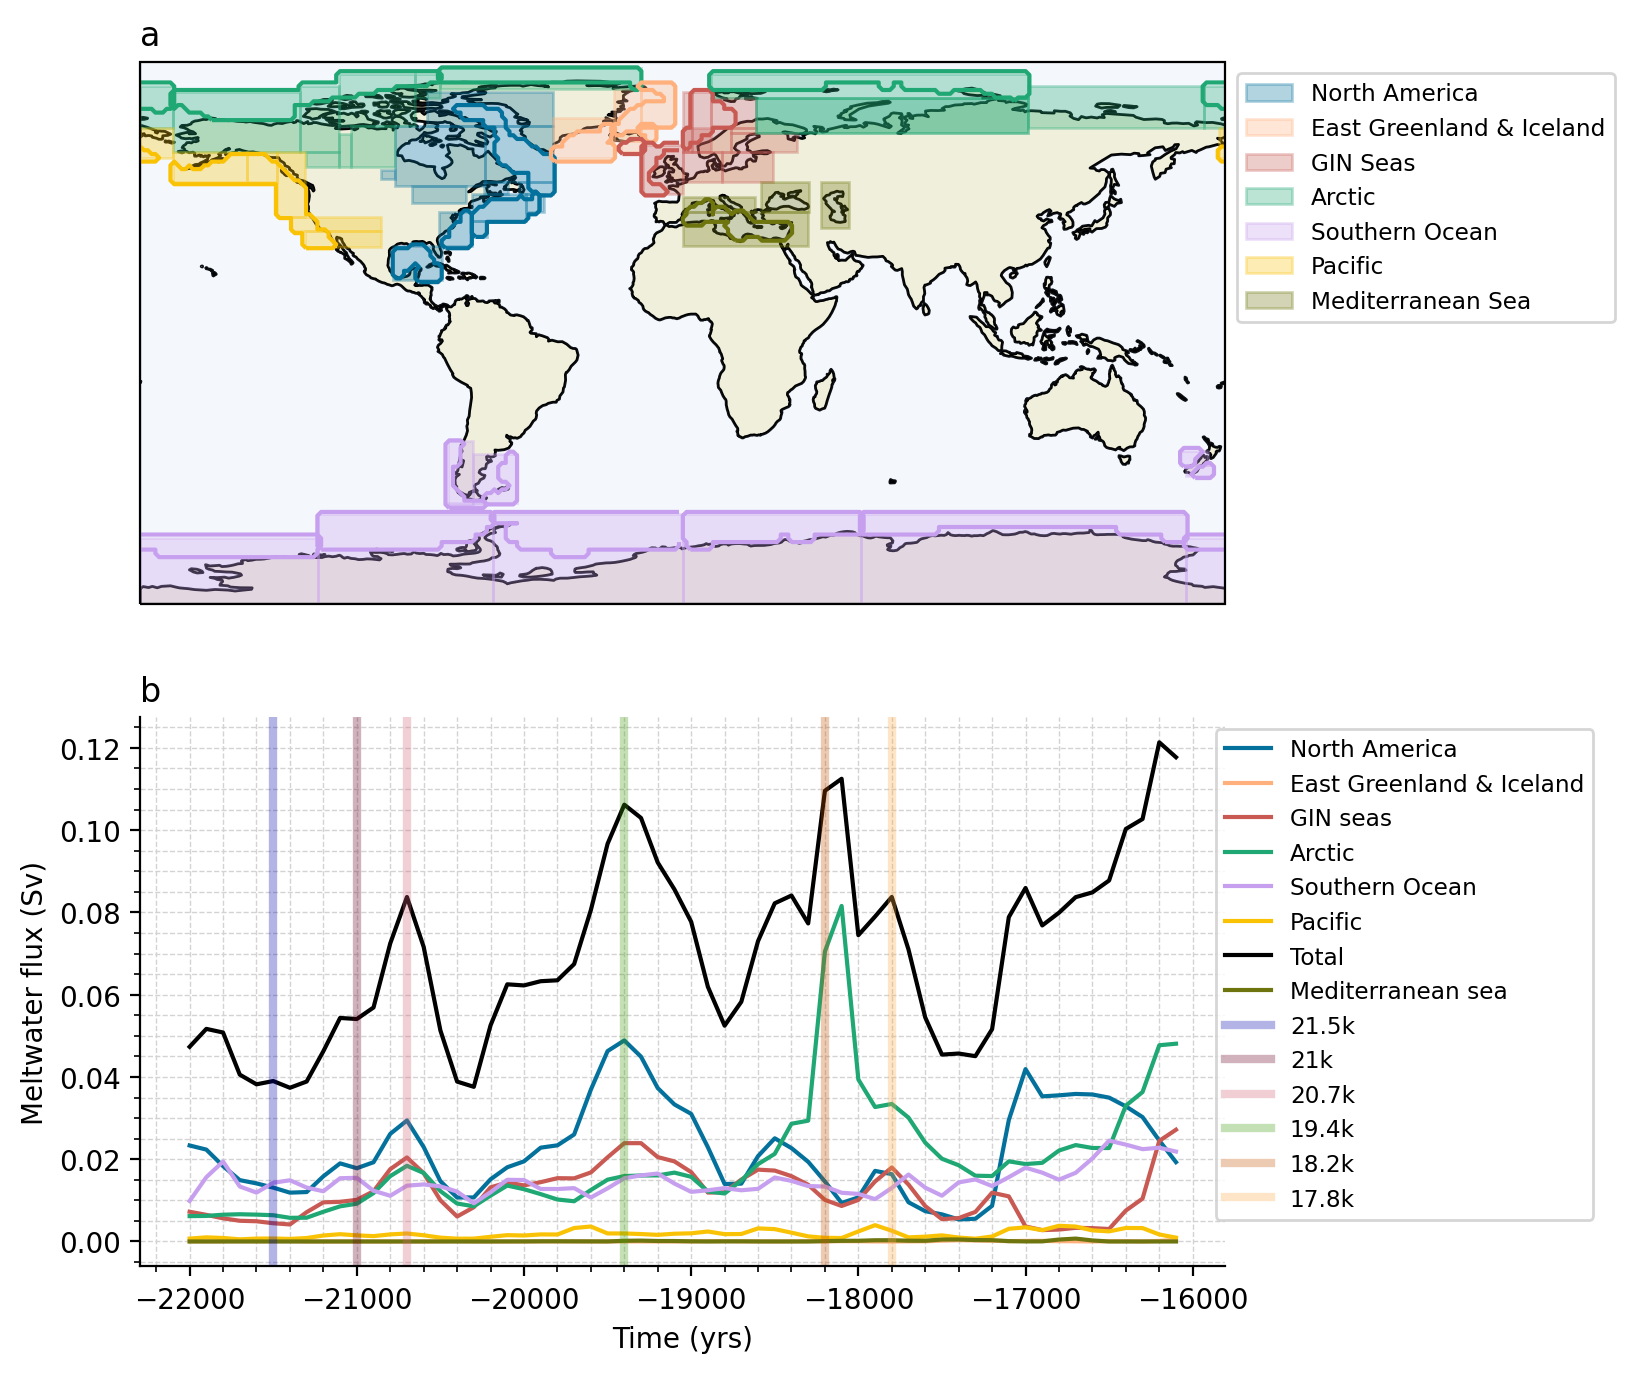

In [49]:
figMap = plt.figure(figsize=(7,8), dpi=200)
projection_map = ccrs.PlateCarree()

axMap = figMap.add_subplot(211, projection = projection_map)
axTs = figMap.add_subplot(212)


# NORTH AMERICA

axMap.fill(cb['USECoast1'].cycle_box()[0], cb['USECoast1'].cycle_box()[1], color='xkcd:ocean blue', linestyle = "-", alpha=0.3, transform=ccrs.PlateCarree(), label="North America")
for region in ['USECoast2', 'USECoast3', 'USECoast4', 'USECoast5', 'USECoast6', 'GrLakes1', 'GoM1', 'BafLab1',
               'BafLab2', 'BafLab3', 'HudBay1', 'HudBay2']:
    axMap.fill(cb[region].cycle_box()[0], cb[region].cycle_box()[1], color='xkcd:ocean blue', linestyle = "-", alpha=0.3, transform=ccrs.PlateCarree())


# EAST GREENLAND & ICELAND

axMap.fill(cb['AtlGr1'].cycle_box()[0], cb['AtlGr1'].cycle_box()[1], color='xkcd:peach', linestyle = "-", alpha=0.3, transform=ccrs.PlateCarree(), label="East Greenland & Iceland")
for region in ['EGrIce1', 'EGrIce2', 'EIceland1', 'SIceland1']:
    axMap.fill(cb[region].cycle_box()[0], cb[rBientôt aussi sur la liste noire de l'Union européenne

Par ailleurs, l'Union européenne a inclus lundi Abramovitch à une nouvelle liste de 12 oligarques russes dans le cadre d'un quatrième train de sanctions contre Moscou. Avant cette extension, 862 personnes et 53 entités russes figuraient déjà sur cette liste noire qui interdit l'entrée sur le territoire de l'UE et permet la saisie de leurs biens.
egion].cycle_box()[1], color='xkcd:peach', linestyle = "-", alpha=0.3, transform=ccrs.PlateCarree())

    
# GIN SEAS

axMap.fill(cb['UKAtl1'].cycle_box()[0], cb['UKAtl1'].cycle_box()[1], color='xkcd:dark salmon', linestyle = "-", alpha=0.3, transform=ccrs.PlateCarree(), label="GIN Seas")
for region in ['EurGIN1', 'EurGIN2', 'EurGIN3', 'EurGIN4', 'EurGIN5', 'EurGIN6', 'Baltic1', 'Baltic2']:
    axMap.fill(cb[region].cycle_box()[0], cb[region].cycle_box()[1], color='xkcd:dark salmon', linestyle = "-", alpha=0.3, transform=ccrs.PlateCarree())

    
# ARCTIC

axMap.fill(cb['GrArc1'].cycle_box()[0], cb['GrArc1'].cycle_box()[1], color='xkcd:jade', linestyle = "-", alpha=0.3, transform=ccrs.PlateCarree(), label="Arctic")
for region in ['NAMArc1', 'NAMArc2', 'NAMArc3', 'NAMArc4', 'NAMArc5', 'NWTerr1', 'NWTerr2', 'SibArc1',
               'SibArc2', 'EurArc1', 'EurArc2', 'EurArc2']:
    axMap.fill(cb[region].cycle_box()[0], cb[region].cycle_box()[1], color='xkcd:jade', linestyle = "-", alpha=0.3, transform=ccrs.PlateCarree())


# SOUTHERN OCEAN

axMap.fill(cb['PatAtl1'].cycle_box()[0], cb['PatAtl1'].cycle_box()[1], color='xkcd:lavender', linestyle = "-", alpha=0.3, transform=ccrs.PlateCarree(), label="Southern Ocean")
for region in ['PatPac1', 'PatPac2', 'AARos1', 'AAAmund', 'AAWeddell', 'AARiiLar', 'AADavis', 'SNZPac1', 'NNZPac1']:
    axMap.fill(cb[region].cycle_box()[0], cb[region].cycle_box()[1], color='xkcd:lavender', linestyle = "-", alpha=0.3, transform=ccrs.PlateCarree())


# PACIFIC

axMap.fill(cb['EPac1'].cycle_box()[0], cb['EPac1'].cycle_box()[1], color='xkcd:goldenrod', linestyle = "-", alpha=0.3, transform=ccrs.PlateCarree(), label="Pacific")
for region in ['EPac2', 'EPac3', 'EPac4', 'EPac5', 'RussPac1']:
    axMap.fill(cb[region].cycle_box()[0], cb[region].cycle_box()[1], color='xkcd:goldenrod', linestyle = "-", alpha=0.3, transform=ccrs.PlateCarree())


# MEDITERRANEAN SEA

axMap.fill(cb['Med1'].cycle_box()[0], cb['Med1'].cycle_box()[1], color='xkcd:olive', linestyle = "-", alpha=0.3, transform=ccrs.PlateCarree(), label="Mediterranean Sea")
for region in ['Med2', 'BlckSea1', 'CaspSea1']:
    axMap.fill(cb[region].cycle_box()[0], cb[region].cycle_box()[1], color='xkcd:olive', linestyle = "-", alpha=0.3, transform=ccrs.PlateCarree())

for region in sr:
    if region['name'] in ['US_East_Coast', 'Gulf_of_Mexico', 'LabradorSea_BaffinBay']:
        axMap.contour(region['region'].grid.lon_center, region['region'].grid.lat_center, region['region'].mask, levels=[True], colors='xkcd:ocean blue', transform=ccrs.PlateCarree(), linewidths=1.5, alpha=1)
    elif region['name'] in ['Greenland_Arctic', 'N_American_Arctic', 'Eurasian_Arctic', 'Siberian_Arctic']:
        axMap.contour(region['region'].grid.lon_center, region['region'].grid.lat_center, region['region'].mask, levels=[True], colors='xkcd:jade', transform=ccrs.PlateCarree(), linewidths=1.5, alpha=1)
    elif region['name'] in ['East_Pacific', 'Russia_Pacific']:
        axMap.contour(region['region'].grid.lon_center, region['region'].grid.lat_center, region['region'].mask, levels=[True], colors='xkcd:goldenrod', transform=ccrs.PlateCarree(), linewidths=1.5, alpha=1)
    elif region['name'] in ['Atlantic_GreenlandIceland', 'EastGreenland_Iceland', 'EastIceland']:
        axMap.contour(region['region'].grid.lon_center, region['region'].grid.lat_center, region['region'].mask, levels=[True], colors='xkcd:peach', transform=ccrs.PlateCarree(), linewidths=1.5, alpha=1)
    elif region['name'] in ['UK_Atlantic', 'Eurasian_GINSeas', 'South_Iceland']:
        axMap.contour(region['region'].grid.lon_center, region['region'].grid.lat_center, region['region'].mask, levels=[True], colors='xkcd:dark salmon', transform=ccrs.PlateCarree(), linewidths=1.5, alpha=1)
    elif region['name'] in ['Mediterranean']:
        axMap.contour(region['region'].grid.lon_center, region['region'].grid.lat_center, region['region'].mask, levels=[True], colors='xkcd:olive', transform=ccrs.PlateCarree(), linewidths=1.5, alpha=1)
    elif region['name'] in ['Patagonia_Atlantic', 'Patagonia_Pacific', 'NorthNewZealand_Pacific', 'SouthNewZealand_Pacific', 'Antarctica_RossSea', 'Antarctica_AmundsenSea', 'Antarctica_WeddellSea', 'Antarctica_RiiserLarsonSea', 'Antarctica_DavisSea']:
        axMap.contour(region['region'].grid.lon_center, region['region'].grid.lat_center, region['region'].mask, levels=[True], colors='xkcd:lavender', transform=ccrs.PlateCarree(), linewidths=1.5, alpha=1)

axMap.set_global()
axMap.legend(fontsize='small', bbox_to_anchor=(1, 1))
axMap.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
axMap.add_feature(cartopy.feature.OCEAN, zorder=0, edgecolor='black', alpha=0.1)
axMap.set_title('a', loc='left')

start, end = 40, 100

axTs.plot(t[start:end], util.running_mean(flux_na[start:end],2), label="North America", color="xkcd:ocean blue", linestyle="-")
axTs.plot(t[start:end], util.running_mean(flux_egi[start:end],2), label="East Greenland & Iceland", color="xkcd:peach", linestyle="-")
axTs.plot(t[start:end], util.running_mean(flux_gin[start:end],2), label="GIN seas", color="xkcd:dark salmon", linestyle="-")
axTs.plot(t[start:end], util.running_mean(flux_arc[start:end],2), label="Arctic", color="xkcd:jade", linestyle="-")
axTs.plot(t[start:end], util.running_mean(flux_ss[start:end],2), label="Southern Ocean", color="xkcd:lavender", linestyle="-")
axTs.plot(t[start:end], util.running_mean(flux_pac[start:end],2), label="Pacific", color="xkcd:goldenrod", linestyle="-")
axTs.plot(t[start:end], util.running_mean(flux_tot[start:end],2), label="Total", color="black", linestyle="-")
axTs.plot(t[start:end], util.running_mean(flux_med[start:end],2), label="Mediterranean sea", color="xkcd:olive", linestyle="-")
axTs.axvline(x=-21500, color="xkcd:royal blue", label="21.5k", linewidth=3, alpha=0.3)
axTs.axvline(x=-21000, color="xkcd:maroon", label="21k", linewidth=3, alpha=0.3)
axTs.axvline(x=-20700, color="xkcd:rose", label="20.7k", linewidth=3, alpha=0.3)
axTs.axvline(x=-19400, color="xkcd:grass green", label="19.4k", linewidth=3, alpha=0.3)
axTs.axvline(x=-18200, color="xkcd:dark orange", label="18.2k", linewidth=3, alpha=0.3)
axTs.axvline(x=-17800, color="xkcd:light orange", label="17.8k", linewidth=3, alpha=0.3)

axTs.legend(loc="upper right", fontsize='small', bbox_to_anchor=(1.35, 1))
axTs.spines['right'].set_visible(False)
axTs.spines['top'].set_visible(False)
axTs.set_xlabel("Time (yrs)")
axTs.set_ylabel("Meltwater flux (Sv)")
axTs.minorticks_on()
axTs.grid(which = "both", color='lightgrey', linestyle='--', linewidth=0.5)
axTs.set_title('b', loc='left')

/nfs/see-fs-01_users/eeymr/.conda/envs/eeymr/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/nfs/see-fs-01_users/eeymr/.conda/envs/eeymr/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: Log scale: values of z <= 0 have been masked
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


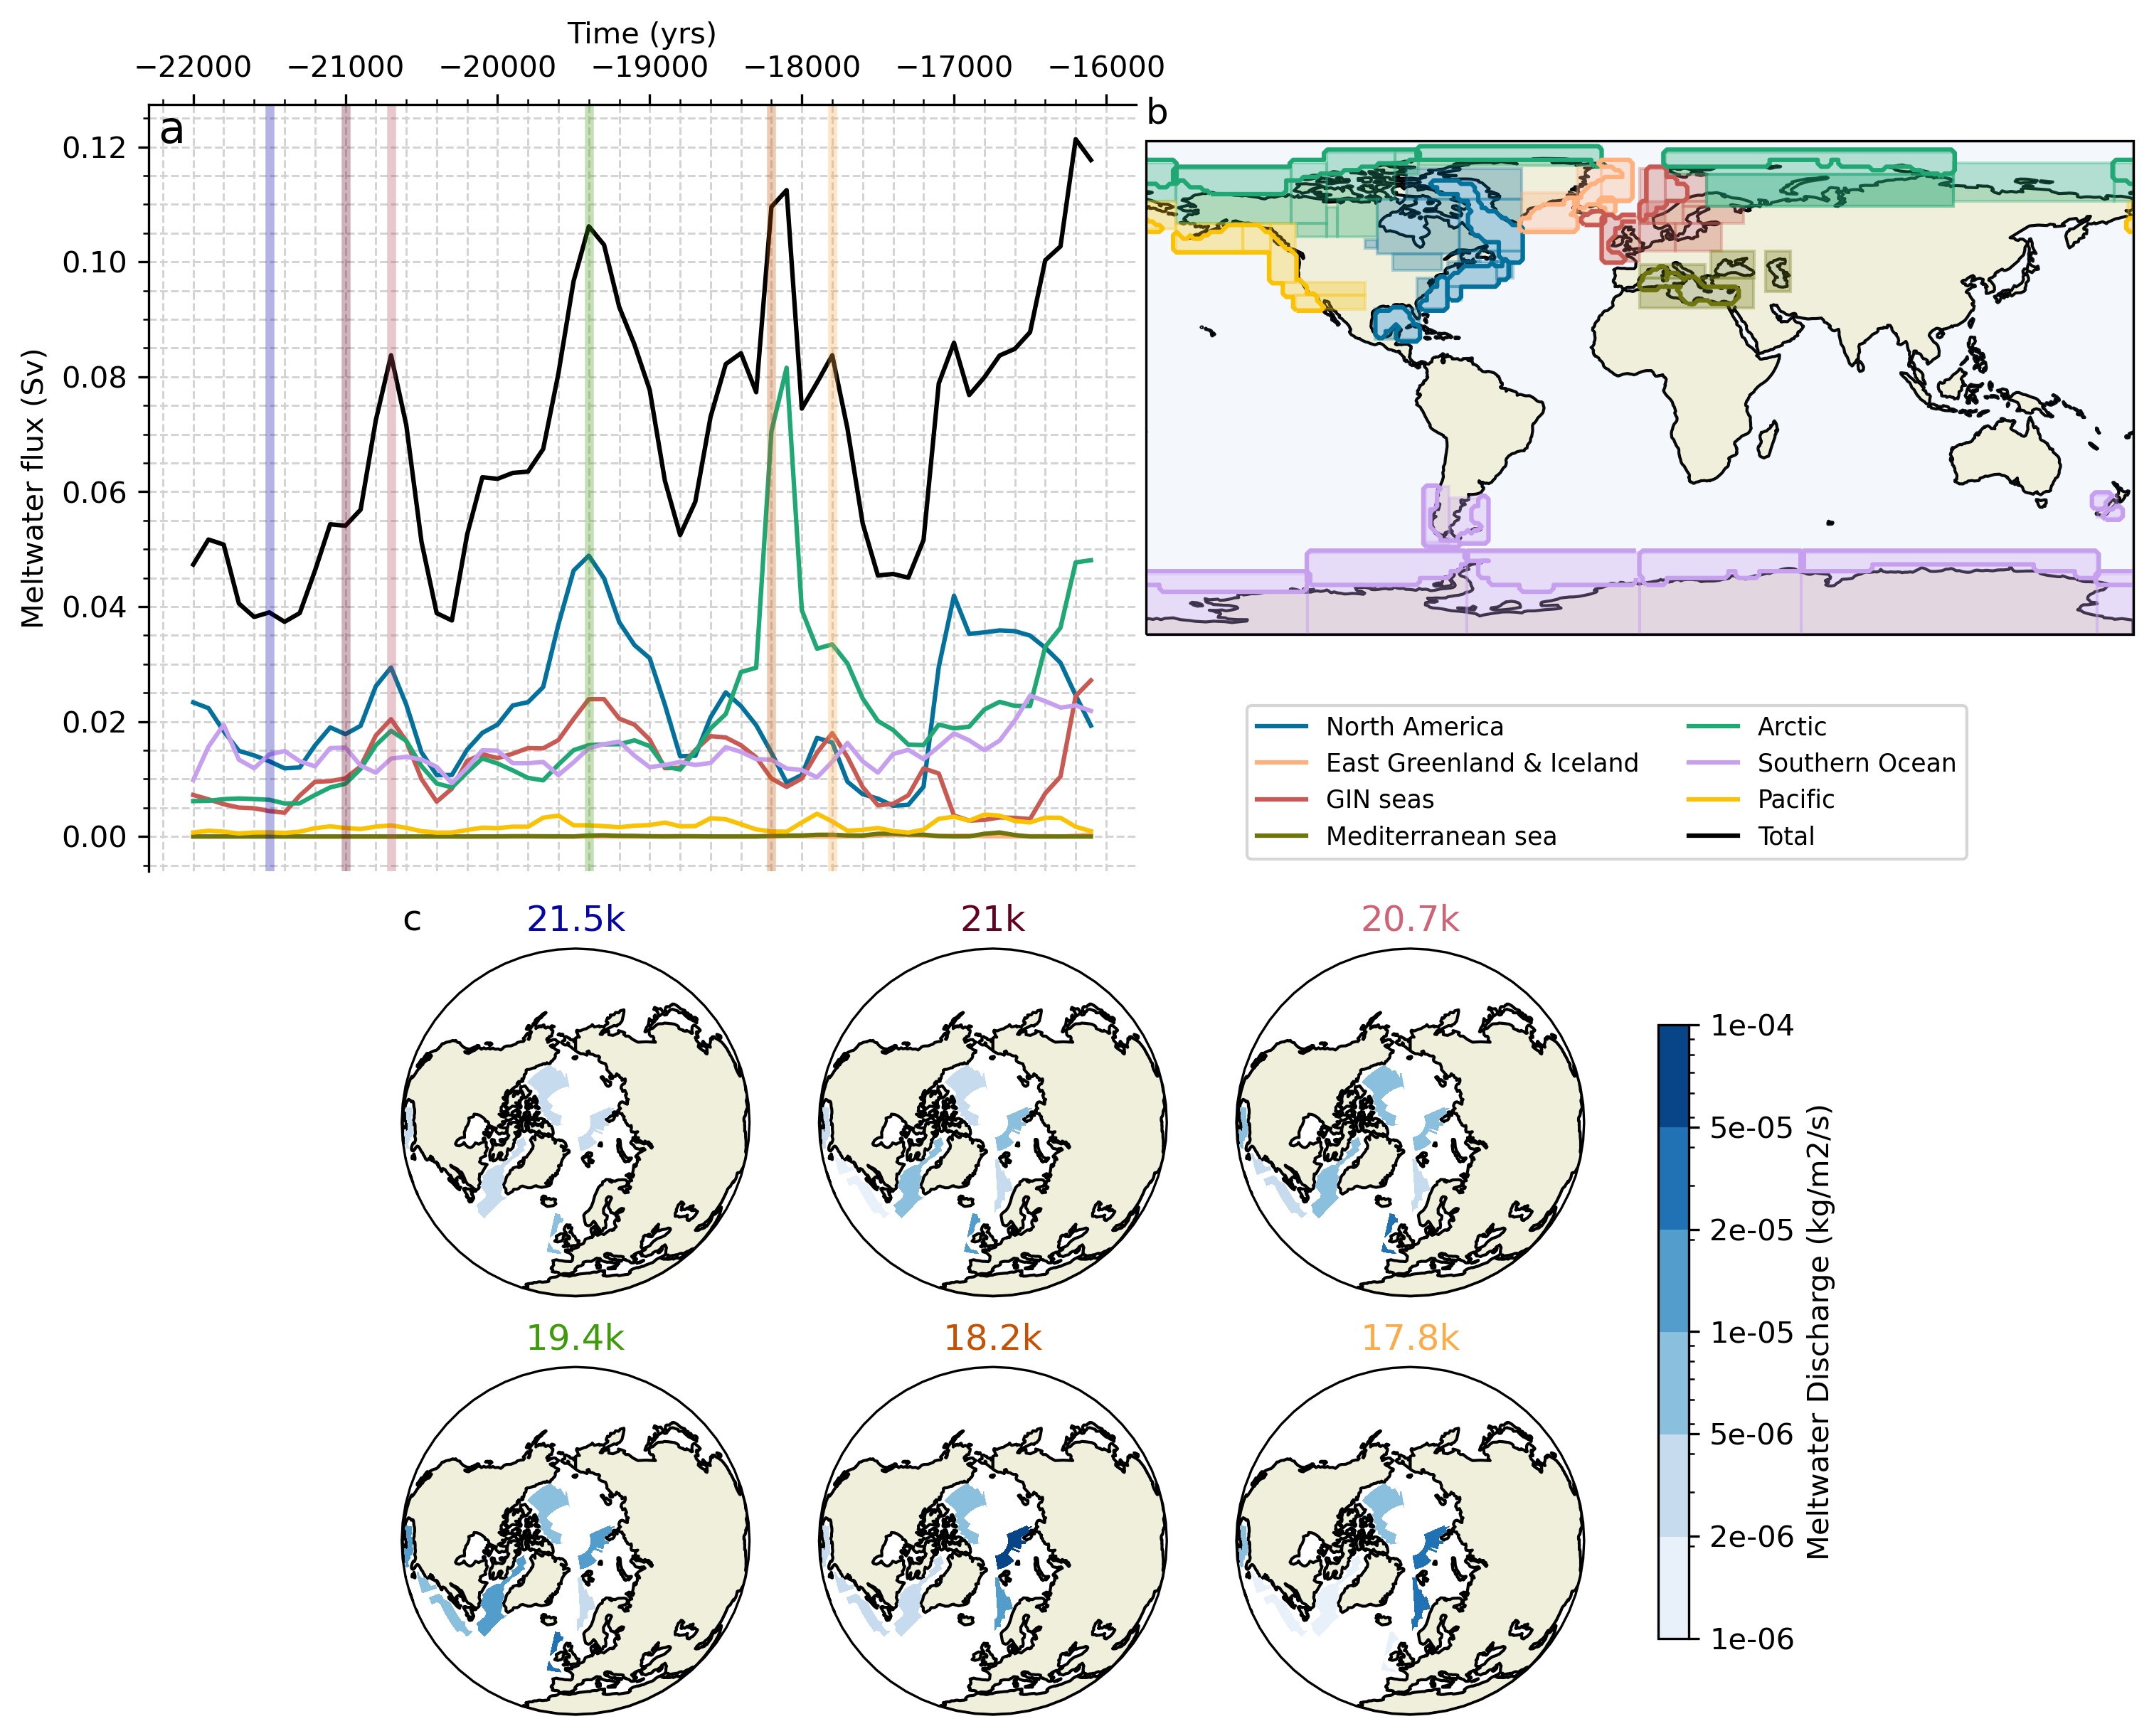

In [73]:
figMap = plt.figure(figsize=(12,10), dpi=300)

grid = figMap.add_gridspec(2, 8, hspace=0.1)

gridup = gridspec.GridSpecFromSubplotSpec(4, 2, wspace=0.01, subplot_spec=grid[0,:])
projection_map = ccrs.PlateCarree()
axTs = figMap.add_subplot(gridup[:,0])
axMap = figMap.add_subplot(gridup[0:3,1], projection = projection_map)

griddown = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=grid[1,1:7])
projection_map = ccrs.NearsidePerspective(central_longitude=0.0, central_latitude=90.0, satellite_height=35785831)
axLGMMin= figMap.add_subplot(griddown[0,0], projection = projection_map)
axLGM = figMap.add_subplot(griddown[0,1], projection = projection_map)
axLGMMax = figMap.add_subplot(griddown[0,2], projection = projection_map)
axNA = figMap.add_subplot(griddown[1,0], projection = projection_map)
axARC = figMap.add_subplot(griddown[1,1], projection = projection_map)
axARCMin = figMap.add_subplot(griddown[1,2], projection = projection_map)

# Time series 

start, end = 40, 100

axTs.plot(t[start:end], util.running_mean(flux_na[start:end],2), label="North America", color="xkcd:ocean blue", linestyle="-")
axTs.plot(t[start:end], util.running_mean(flux_egi[start:end],2), label="East Greenland & Iceland", color="xkcd:peach", linestyle="-")
axTs.plot(t[start:end], util.running_mean(flux_gin[start:end],2), label="GIN seas", color="xkcd:dark salmon", linestyle="-")
axTs.plot(t[start:end], util.running_mean(flux_med[start:end],2), label="Mediterranean sea", color="xkcd:olive", linestyle="-")
axTs.plot(t[start:end], util.running_mean(flux_arc[start:end],2), label="Arctic", color="xkcd:jade", linestyle="-")
axTs.plot(t[start:end], util.running_mean(flux_ss[start:end],2), label="Southern Ocean", color="xkcd:lavender", linestyle="-")
axTs.plot(t[start:end], util.running_mean(flux_pac[start:end],2), label="Pacific", color="xkcd:goldenrod", linestyle="-")
axTs.plot(t[start:end], util.running_mean(flux_tot[start:end],2), label="Total", color="black", linestyle="-")
axTs.axvline(x=-21500, color="xkcd:royal blue", linewidth=3, alpha=0.3)
axTs.axvline(x=-21000, color="xkcd:maroon", linewidth=3, alpha=0.3)
axTs.axvline(x=-20700, color="xkcd:dark rose", linewidth=3, alpha=0.3)
axTs.axvline(x=-19400, color="xkcd:grass green", linewidth=3, alpha=0.3)
axTs.axvline(x=-18200, color="xkcd:dark orange", linewidth=3, alpha=0.3)
axTs.axvline(x=-17800, color="xkcd:light orange", linewidth=3, alpha=0.3)

axTs.legend(loc="lower left", fontsize='small', bbox_to_anchor=(1.1, 0, 1, 1), ncol=2)
axTs.spines['right'].set_visible(False)
axTs.spines['bottom'].set_visible(False)
axTs.xaxis.set_ticks_position('top')
axTs.xaxis.set_label_position('top')
axTs.set_xlabel("Time (yrs)")
axTs.set_ylabel("Meltwater flux (Sv)")
axTs.minorticks_on()
axTs.grid(which = "both", color='lightgrey', linestyle='--', linewidth=0.7)
axTs.annotate('a', xy=(0.01,0.95), xycoords='axes fraction', size=15)

# Spreading Regions

# NORTH AMERICA

axMap.fill(cb['USECoast1'].cycle_box()[0], cb['USECoast1'].cycle_box()[1], color='xkcd:ocean blue', linestyle = "-", alpha=0.3, transform=ccrs.PlateCarree(), label="North America")
for region in ['USECoast2', 'USECoast3', 'USECoast4', 'USECoast5', 'USECoast6', 'GrLakes1', 'GoM1', 'BafLab1',
               'BafLab2', 'BafLab3', 'HudBay1', 'HudBay2']:
    axMap.fill(cb[region].cycle_box()[0], cb[region].cycle_box()[1], color='xkcd:ocean blue', linestyle = "-", alpha=0.3, transform=ccrs.PlateCarree())


# EAST GREENLAND & ICELAND

axMap.fill(cb['AtlGr1'].cycle_box()[0], cb['AtlGr1'].cycle_box()[1], color='xkcd:peach', linestyle = "-", alpha=0.3, transform=ccrs.PlateCarree(), label="East Greenland & Iceland")
for region in ['EGrIce1', 'EGrIce2', 'EIceland1', 'SIceland1']:
    axMap.fill(cb[region].cycle_box()[0], cb[region].cycle_box()[1], color='xkcd:peach', linestyle = "-", alpha=0.3, transform=ccrs.PlateCarree())

    
# GIN SEAS

axMap.fill(cb['UKAtl1'].cycle_box()[0], cb['UKAtl1'].cycle_box()[1], color='xkcd:dark salmon', linestyle = "-", alpha=0.3, transform=ccrs.PlateCarree(), label="GIN Seas")
for region in ['EurGIN1', 'EurGIN2', 'EurGIN3', 'EurGIN4', 'EurGIN5', 'EurGIN6', 'Baltic1', 'Baltic2']:
    axMap.fill(cb[region].cycle_box()[0], cb[region].cycle_box()[1], color='xkcd:dark salmon', linestyle = "-", alpha=0.3, transform=ccrs.PlateCarree())

    
# ARCTIC

axMap.fill(cb['GrArc1'].cycle_box()[0], cb['GrArc1'].cycle_box()[1], color='xkcd:jade', linestyle = "-", alpha=0.3, transform=ccrs.PlateCarree(), label="Arctic")
for region in ['NAMArc1', 'NAMArc2', 'NAMArc3', 'NAMArc4', 'NAMArc5', 'NWTerr1', 'NWTerr2', 'SibArc1',
               'SibArc2', 'EurArc1', 'EurArc2', 'EurArc2']:
    axMap.fill(cb[region].cycle_box()[0], cb[region].cycle_box()[1], color='xkcd:jade', linestyle = "-", alpha=0.3, transform=ccrs.PlateCarree())


# SOUTHERN OCEAN

axMap.fill(cb['PatAtl1'].cycle_box()[0], cb['PatAtl1'].cycle_box()[1], color='xkcd:lavender', linestyle = "-", alpha=0.3, transform=ccrs.PlateCarree(), label="Southern Ocean")
for region in ['PatPac1', 'PatPac2', 'AARos1', 'AAAmund', 'AAWeddell', 'AARiiLar', 'AADavis', 'SNZPac1', 'NNZPac1']:
    axMap.fill(cb[region].cycle_box()[0], cb[region].cycle_box()[1], color='xkcd:lavender', linestyle = "-", alpha=0.3, transform=ccrs.PlateCarree())


# PACIFIC

axMap.fill(cb['EPac1'].cycle_box()[0], cb['EPac1'].cycle_box()[1], color='xkcd:goldenrod', linestyle = "-", alpha=0.3, transform=ccrs.PlateCarree(), label="Pacific")
for region in ['EPac2', 'EPac3', 'EPac4', 'EPac5', 'RussPac1']:
    axMap.fill(cb[region].cycle_box()[0], cb[region].cycle_box()[1], color='xkcd:goldenrod', linestyle = "-", alpha=0.3, transform=ccrs.PlateCarree())


# MEDITERRANEAN SEA

axMap.fill(cb['Med1'].cycle_box()[0], cb['Med1'].cycle_box()[1], color='xkcd:olive', linestyle = "-", alpha=0.3, transform=ccrs.PlateCarree(), label="Mediterranean Sea")
for region in ['Med2', 'BlckSea1', 'CaspSea1']:
    axMap.fill(cb[region].cycle_box()[0], cb[region].cycle_box()[1], color='xkcd:olive', linestyle = "-", alpha=0.3, transform=ccrs.PlateCarree())

for region in sr:
    if region['name'] in ['US_East_Coast', 'Gulf_of_Mexico', 'LabradorSea_BaffinBay']:
        axMap.contour(region['region'].grid.lon_center, region['region'].grid.lat_center, region['region'].mask, 
                      levels=[True], colors='xkcd:ocean blue', transform=ccrs.PlateCarree(), linewidths=1.5, alpha=1)
    elif region['name'] in ['Greenland_Arctic', 'N_American_Arctic', 'Eurasian_Arctic', 'Siberian_Arctic']:
        axMap.contour(region['region'].grid.lon_center, region['region'].grid.lat_center, region['region'].mask,
                      levels=[True], colors='xkcd:jade', transform=ccrs.PlateCarree(), linewidths=1.5, alpha=1)
    elif region['name'] in ['East_Pacific', 'Russia_Pacific']:
        axMap.contour(region['region'].grid.lon_center, region['region'].grid.lat_center, region['region'].mask,
                      levels=[True], colors='xkcd:goldenrod', transform=ccrs.PlateCarree(), linewidths=1.5, alpha=1)
    elif region['name'] in ['Atlantic_GreenlandIceland', 'EastGreenland_Iceland', 'EastIceland']:
        axMap.contour(region['region'].grid.lon_center, region['region'].grid.lat_center, region['region'].mask,
                      levels=[True], colors='xkcd:peach', transform=ccrs.PlateCarree(), linewidths=1.5, alpha=1)
    elif region['name'] in ['UK_Atlantic', 'Eurasian_GINSeas', 'South_Iceland']:
        axMap.contour(region['region'].grid.lon_center, region['region'].grid.lat_center, region['region'].mask,
                      levels=[True], colors='xkcd:dark salmon', transform=ccrs.PlateCarree(), linewidths=1.5, alpha=1)
    elif region['name'] in ['Mediterranean']:
        axMap.contour(region['region'].grid.lon_center, region['region'].grid.lat_center, region['region'].mask,
                      levels=[True], colors='xkcd:olive', transform=ccrs.PlateCarree(), linewidths=1.5, alpha=1)
    elif region['name'] in ['Patagonia_Atlantic', 'Patagonia_Pacific', 'NorthNewZealand_Pacific', 'SouthNewZealand_Pacific', 'Antarctica_RossSea', 'Antarctica_AmundsenSea', 'Antarctica_WeddellSea', 'Antarctica_RiiserLarsonSea', 'Antarctica_DavisSea']:
        axMap.contour(region['region'].grid.lon_center, region['region'].grid.lat_center, region['region'].mask, 
                      levels=[True], colors='xkcd:lavender', transform=ccrs.PlateCarree(), linewidths=1.5, alpha=1)

axMap.set_global()
axMap.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
axMap.add_feature(cartopy.feature.OCEAN, zorder=0, edgecolor='black', alpha=0.1)
axMap.set_title('b', loc='left')


# Meltwater influx

bounds = np.array([10**(-6), 2*10**(-6), 5*10**(-6), 10**(-5), 2*10**(-5), 5*10**(-5), 10**(-4)])
norm = mpl.colors.Normalize(vmin=0, vmax=10**(-4))

axLGMMin.contourf(lon, lat, mw_215, cmap = "Blues", levels=bounds, norm=mpl.colors.LogNorm(), transform=ccrs.PlateCarree())
axLGMMin.set_global()
axLGMMin.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
axLGMMin.set_title("21.5k", color="xkcd:royal blue")
axLGMMin.set_title('c', loc='left')

axLGM.contourf(lon, lat, mw_21, cmap = "Blues", levels=bounds, norm=mpl.colors.LogNorm(), transform=ccrs.PlateCarree())
axLGM.set_global()
axLGM.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
axLGM.set_title("21k", color="xkcd:maroon")

axLGMMax.contourf(lon, lat, mw_207, cmap = "Blues", levels=bounds, norm=mpl.colors.LogNorm(), transform=ccrs.PlateCarree())
axLGMMax.set_global()
axLGMMax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
axLGMMax.set_title("20.7k", color="xkcd:rose")

axNA.contourf(lon, lat, mw_194, cmap = "Blues", levels=bounds, norm=mpl.colors.LogNorm(), transform=ccrs.PlateCarree())
axNA.set_global()
axNA.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
axNA.set_title("19.4k", color="xkcd:grass green")

cm = axARC.contourf(lon, lat, mw_182, cmap = "Blues", levels=bounds, norm=mpl.colors.LogNorm(), transform=ccrs.PlateCarree())
axARC.set_global()
axARC.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
axARC.set_title("18.2k", color="xkcd:dark orange")

axARCMin.contourf(lon, lat, mw_178, cmap = "Blues", levels=bounds, norm=mpl.colors.LogNorm(), transform=ccrs.PlateCarree())
axARCMin.set_global()
axARCMin.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
axARCMin.set_title("17.8k", color="xkcd:light orange")

figMap.colorbar(mappable=cm, ax=[axLGMMin, axLGM, axLGMMax, axNA, axARC, axARCMin], ticks = bounds, shrink=0.8, format='%.0e', label="Meltwater Discharge (kg/m2/s)")


## Smoothing bathymetry algorithm

### Figure X - Crash

In [24]:
ds = xr.open_dataset("~/work/troubleshooting/2112_share_smooth_bathymetry/xohzno#pf000003879dc+_stream.nc")

pre_crash_stream = ds.field611.isel(t=0).isel(unspecified=0, drop=True)
crash_stream = ds.field611.isel(t=-30).isel(unspecified=0, drop=True)
post_crash_stream = ds.field611.isel(t=-23).isel(unspecified=0, drop=True)

__ Initialsing the norm from the array sequence
__ Initialsing the norm from the array sequence
__ Initialsing the norm from the array sequence


Text(0, 1.02, 'c')

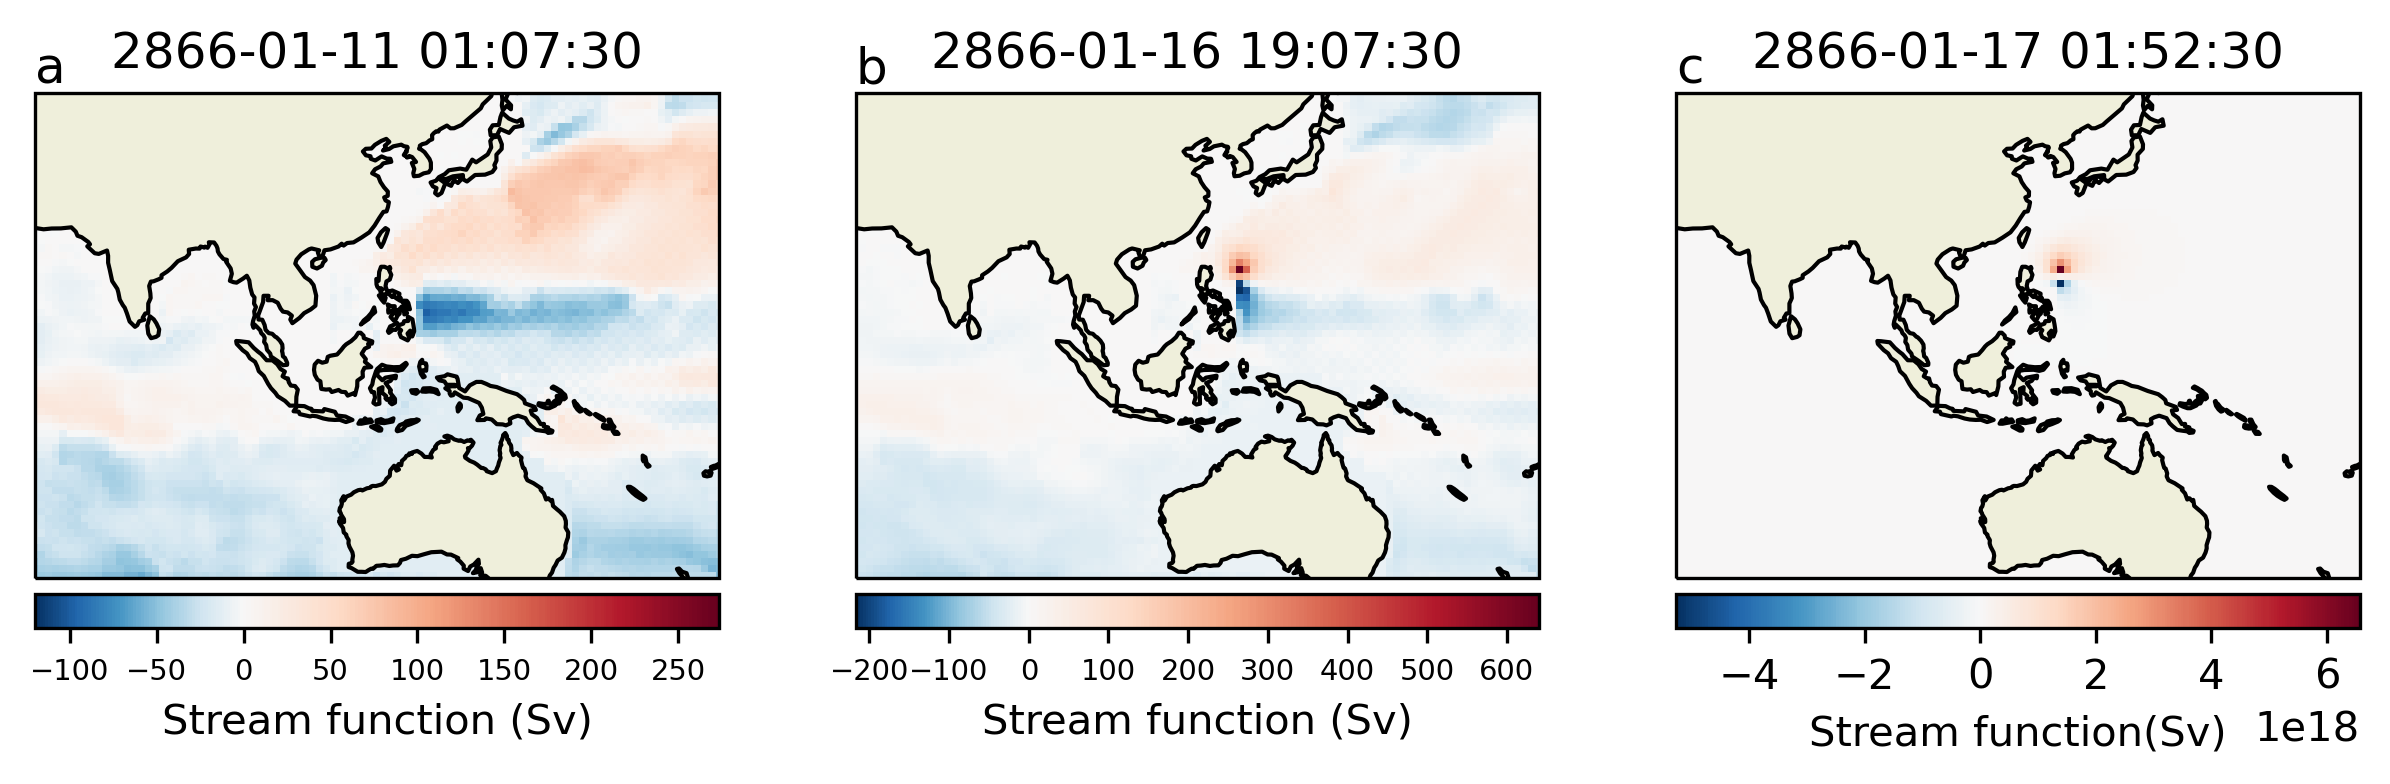

In [29]:
figMap, (axPreCrash, axCrash, axPostCrash) = plt.subplots(nrows=1, ncols=3, figsize=(10,7), dpi=300, subplot_kw={'projection':ccrs.PlateCarree()})

norm = plots.TwoSlopeNorm(vcenter=0, in_values=[pre_crash_stream.values*10**(-12)])
cm = axPreCrash.pcolormesh(pre_crash_stream.longitude_1, pre_crash_stream.latitude_1, pre_crash_stream.values*10**(-12), cmap="RdBu_r", norm=norm, transform=ccrs.PlateCarree())
axPreCrash.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
axPreCrash.set_extent([60,180,-20,30])
axPreCrash.set_title(pre_crash_stream.t.values - datetime.timedelta(days=1000*365))
cbar = figMap.colorbar(mappable=cm, ax=[axPreCrash], label="Stream function (Sv)", orientation='horizontal', pad=0.01)
cbar.ax.tick_params(labelsize='x-small')

norm = plots.TwoSlopeNorm(vcenter=0, in_values=[crash_stream.values*10**(-12)])
cm = axCrash.pcolormesh(crash_stream.longitude_1, crash_stream.latitude_1, crash_stream.values*10**(-12), cmap="RdBu_r", norm=norm, transform=ccrs.PlateCarree())
axCrash.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
axCrash.set_extent([60,180,-20,30])
axCrash.set_title(crash_stream.t.values - datetime.timedelta(days=1000*365))
cbar = figMap.colorbar(mappable=cm, ax=[axCrash], label="Stream function (Sv)", orientation='horizontal', pad=0.01)
cbar.ax.tick_params(labelsize='x-small')

norm = plots.TwoSlopeNorm(vcenter=0, in_values=[post_crash_stream.values*10**(-12)])
cm = axPostCrash.pcolormesh(post_crash_stream.longitude_1, post_crash_stream.latitude_1, post_crash_stream.values*10**(-12), cmap="RdBu_r", norm=norm, transform=ccrs.PlateCarree())
axPostCrash.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
axPostCrash.set_extent([60,180,-20,30])
axPostCrash.set_title(post_crash_stream.t.values - datetime.timedelta(days=1000*365))
cbar = figMap.colorbar(mappable=cm, ax=[axPostCrash], label="Stream function(Sv)", orientation='horizontal', pad=0.01)
cbar.ax.tick_params(labelsize='medium')

axPreCrash.annotate('a', xy=(0, 1.02), xycoords='axes fraction', size=12)
axCrash.annotate('b', xy=(0, 1.02), xycoords='axes fraction', size=12)
axPostCrash.annotate('c', xy=(0, 1.02), xycoords='axes fraction', size=12)

### Figure X - Effect of the smoothing algorithm

In [4]:
spans = {'start_smooth':4900, 'end_smooth':4999, 'start_raw':3000, 'end_raw':3100}

In [9]:
bath_raw, bath_smooth = {}, {}
stream_raw, stream_smooth = {}, {}
precip_raw, precip_smooth = {}, {}
sst_raw, sst_smooth = {}, {}
sss_raw, sss_smooth = {}, {}
sat_raw, sat_smooth = {}, {}
p_value = 0.1

sat_raw['xoupa'] = hcm3.SATATS('xoupa', start_year=spans['start_raw'], end_year=spans['end_raw']-1, chunks=10).sat()
sat_smooth['xoupa'] = hcm3.SATATS('xoupa', start_year=spans['start_smooth'], end_year=spans['end_smooth'], chunks=10).sat()
sat_ttest = util.ttest(sat_raw['xoupa'].values(), sat_smooth['xoupa'].values(), p_value)
sat_anmly = np.mean(sat_smooth['xoupa'].values(), axis=0) - np.mean(sat_raw['xoupa'].values(), axis=0)

sst_raw['xoupa'] = hcm3.SSTATS('xoupa', start_year=spans['start_raw'], end_year=spans['end_raw']-1, chunks=10).sst()
sst_smooth['xoupa'] = hcm3.SSTATS('xoupa', start_year=spans['start_smooth'], end_year=spans['end_smooth'], chunks=10).sst()
sst_ttest = util.ttest(sst_raw['xoupa'].values(), sst_smooth['xoupa'].values(), p_value)
sst_anmly = np.mean(sst_smooth['xoupa'].values(), axis=0) - np.mean(sst_raw['xoupa'].values(), axis=0)

sss_raw['xoupa'] = hcm3.SAL01ATS('xoupa', start_year=spans['start_raw'], end_year=spans['end_raw']-1, chunks=10).salinity()
sss_smooth['xoupa'] = hcm3.SAL01ATS('xoupa', start_year=spans['start_smooth'], end_year=spans['end_smooth'], chunks=10).salinity()
sss_ttest = util.ttest(sss_raw['xoupa'].values(), sss_smooth['xoupa'].values(), p_value)
sss_anmly = np.mean(sss_smooth['xoupa'].values(), axis=0) - np.mean(sss_raw['xoupa'].values(), axis=0)

stream_raw['xoupa'] = hcm3.OCNSTREAMATS('xoupa', start_year=spans['start_raw'], end_year=spans['end_raw']-1, chunks=10).stream()
stream_smooth['xoupa'] = hcm3.OCNSTREAMATS('xoupa', start_year=spans['start_smooth'], end_year=spans['end_smooth'], chunks=10).stream()
stream_ttest = util.ttest(stream_raw['xoupa'].values(), stream_smooth['xoupa'].values(), p_value)
stream_anmly = np.mean(stream_smooth['xoupa'].values(), axis=0) - np.mean(stream_raw['xoupa'].values(), axis=0)

precip_raw['xoupa'] = hcm3.PRECIPATS('xoupa', start_year=spans['start_raw'], end_year=spans['end_raw']-1, chunks=10).precip()
precip_smooth['xoupa'] = hcm3.PRECIPATS('xoupa', start_year=spans['start_smooth'], end_year=spans['end_smooth'], chunks=10).precip()
precip_ttest = util.ttest(precip_raw['xoupa'].values(), precip_smooth['xoupa'].values(), p_value)
precip_anmly = np.mean(precip_smooth['xoupa'].values(), axis=0) - np.mean(precip_raw['xoupa'].values(), axis=0)

bath_raw['xoupa'] = util.extract_bathymetry(xr.open_dataset("/nfs/see-fs-01_users/eeymr/dump2hold/xoupa/pg/xoupao#pg000003000c1+.nc"))
bath_smooth['xoupa'] = util.extract_bathymetry(xr.open_dataset("/nfs/see-fs-01_users/eeymr/dump2hold/xoupa/pg/xoupao#pg000004900c1+.nc"))

__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : xoupa between years 3000 and 3099.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : xoupa between years 4900 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SSTATS'> : xoupa between years 3000 and 3099.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SST.
____ Coordinates imported in the GeoDataArray instance.
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SSTATS'> : xoupa between years 4900 and 4999.
____ Import succeeded.
____ Coordin

NameError: name 'extract_bathymetry' is not defined

__ Initialsing the norm from the array sequence
__ Initialsing the norm from the array sequence
__ Initialsing the norm from the array sequence
__ Initialsing the norm from the array sequence
__ Initialsing the norm from the array sequence
__ Initialsing the norm from the array sequence


Text(0, 1.05, 'f')

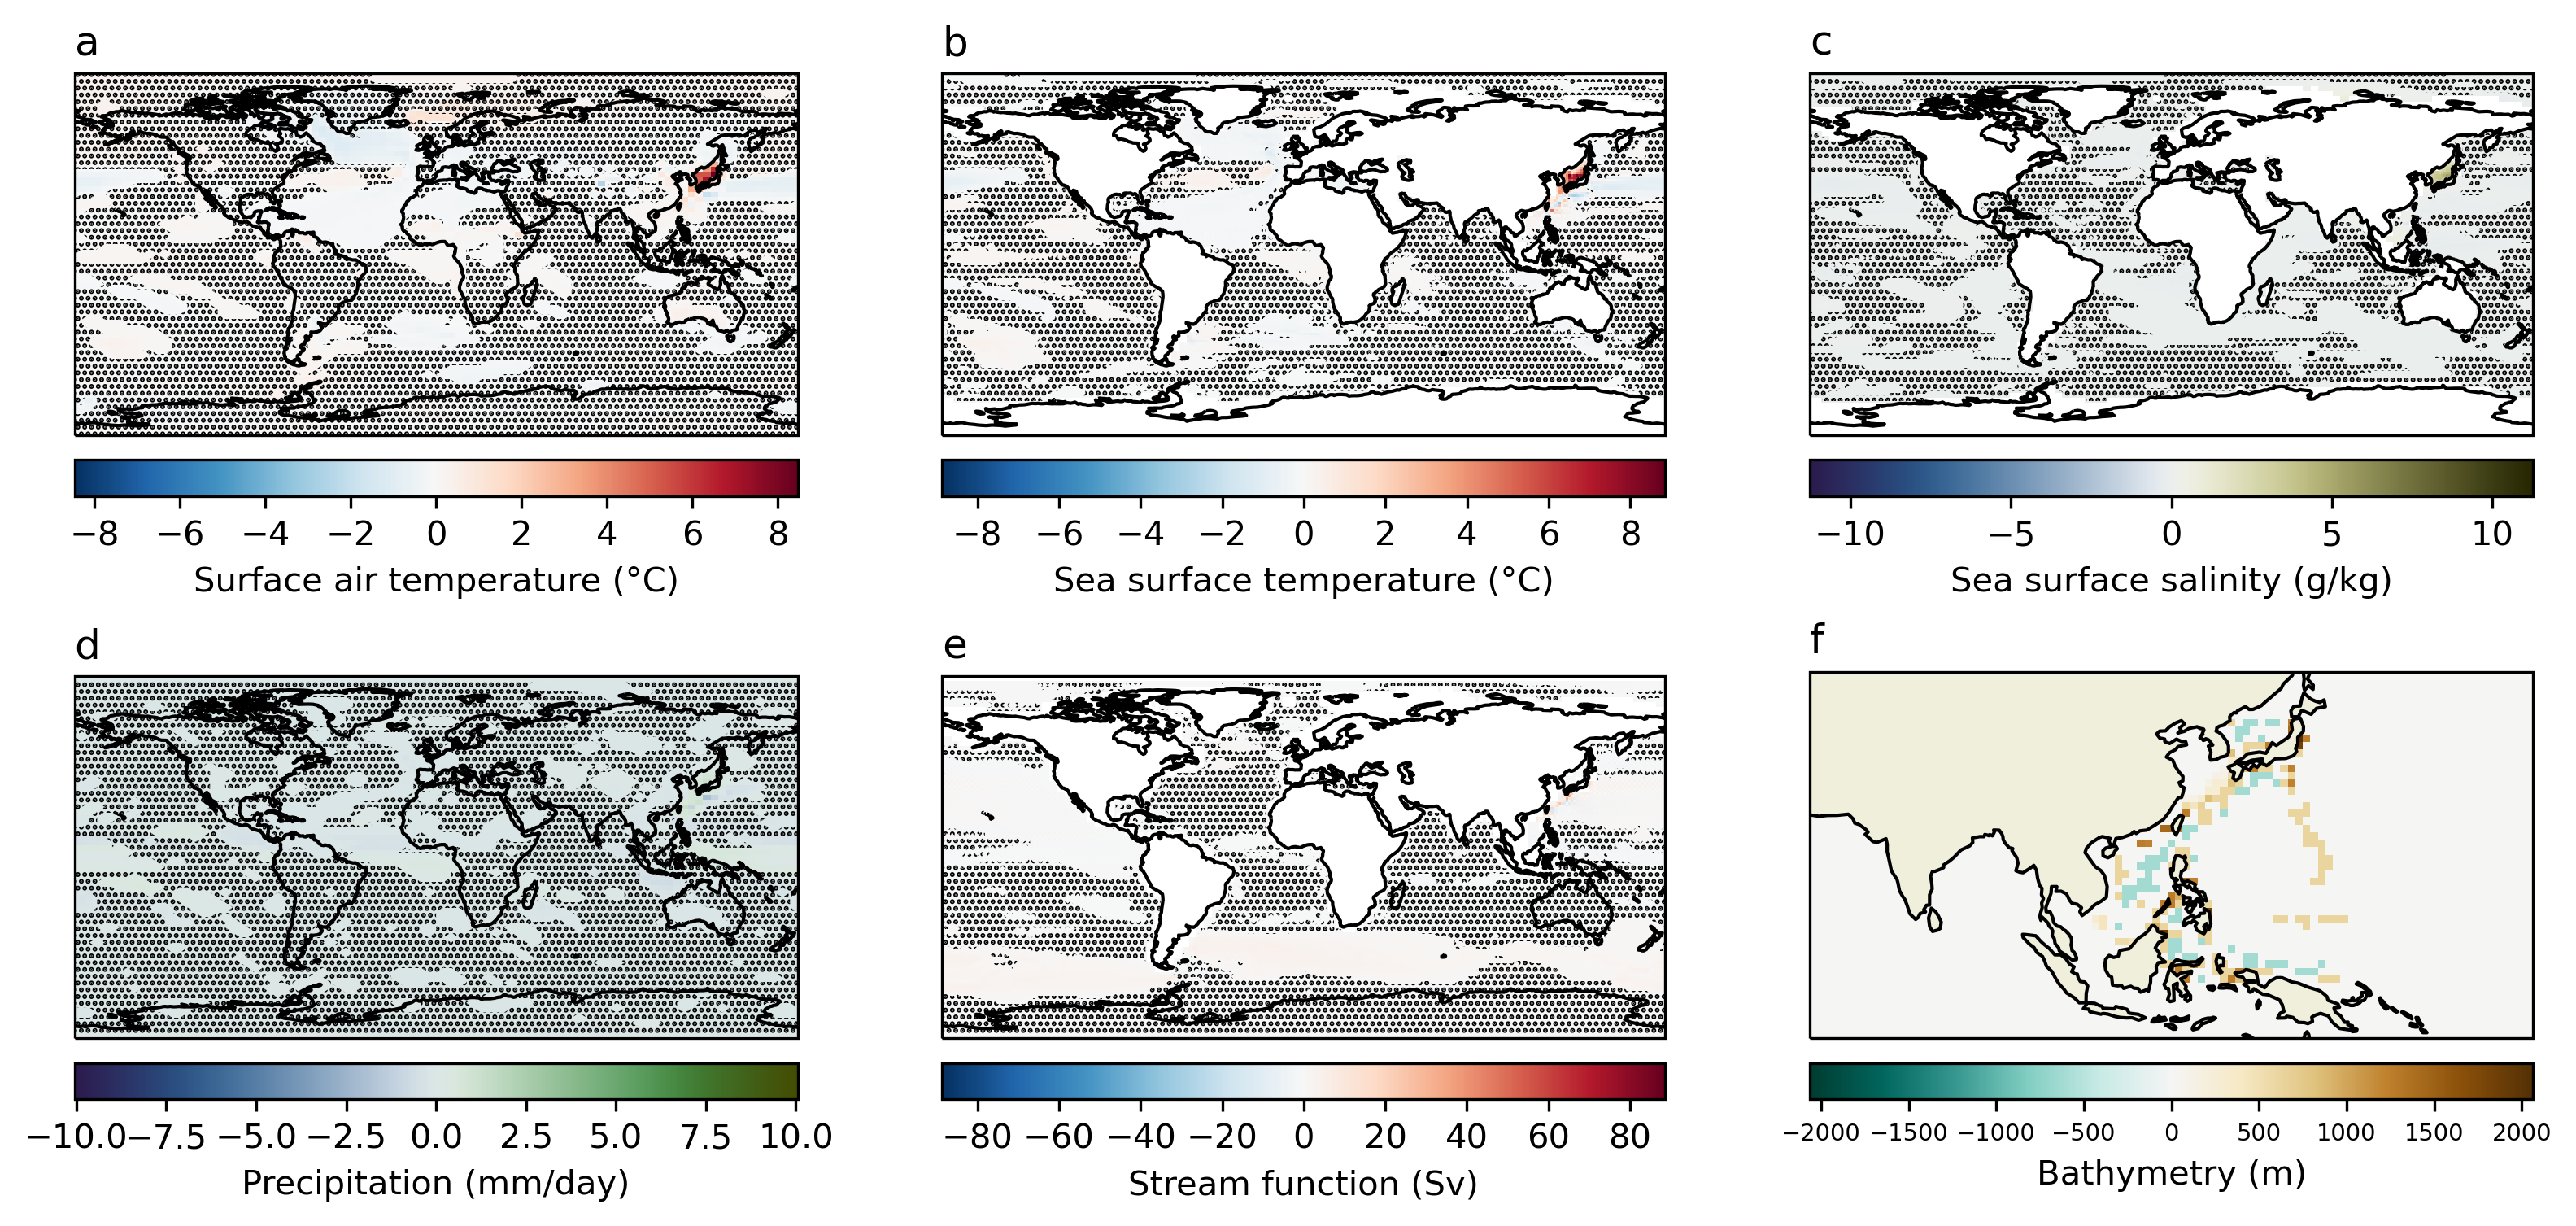

In [19]:
figMap, ((axSAT, axSST, axSSS), (axPrecip, axStream, axBath)) = plt.subplots(nrows=2, ncols=3, figsize=(13,6), dpi=300, subplot_kw={'projection':ccrs.PlateCarree()})

norm_sat = plots.TwoSlopeNorm(vcenter=0., symetrical=True, in_values=[sat_anmly])
cm_sat = axSAT.pcolormesh(sat_smooth['xoupa'].lon_p, sat_smooth['xoupa'].lat_p, sat_anmly, cmap="RdBu_r", norm=norm_sat, transform=ccrs.PlateCarree())
axSAT.contourf(sat_smooth['xoupa'].lon_p, sat_smooth['xoupa'].lat_p, 
               np.where(sat_ttest==False, sat_ttest, np.nan),
               hatches=["......"], cmap='gray', alpha=0)
axSAT.coastlines()
axSAT.set_global()
figMap.colorbar(mappable=cm_sat, ax=axSAT, label="Surface air temperature (°C)", orientation='horizontal', pad=0.05)

norm_sst = plots.TwoSlopeNorm(vcenter=0., symetrical=True, in_values=[sst_anmly])
cm_sst = axSST.pcolormesh(sst_smooth['xoupa'].lon_p, sst_smooth['xoupa'].lat_p, sst_anmly, norm=norm_sst, cmap="RdBu_r", transform=ccrs.PlateCarree())
axSST.contourf(sst_smooth['xoupa'].lon_p, sst_smooth['xoupa'].lat_p, 
               np.where(sst_ttest==False, sst_ttest, np.nan),
               hatches=["......"], cmap='gray', alpha=0)
axSST.coastlines()
axSST.set_global()
figMap.colorbar(mappable=cm_sst, ax=axSST, label="Sea surface temperature (°C)", orientation='horizontal', pad=0.05)

norm_sss = plots.TwoSlopeNorm(vcenter=0., symetrical=True, in_values=[sss_smooth['xoupa'].values() - sss_raw['xoupa'].values()])
cm_sss = axSSS.pcolormesh(sss_smooth['xoupa'].lon_p, sss_smooth['xoupa'].lat_p, sss_anmly, cmap=SCM6.broc, norm=norm_sss, transform=ccrs.PlateCarree())
axSSS.contourf(sss_smooth['xoupa'].lon_p, sss_smooth['xoupa'].lat_p, 
               np.where(sss_ttest==False, sss_ttest, np.nan),
               hatches=["......"], cmap='gray', alpha=0)
axSSS.coastlines()
axSSS.set_global()
figMap.colorbar(mappable=cm_sss, ax=axSSS, label="Sea surface salinity (g/kg)", orientation='horizontal', pad=0.05)

norm_precip = plots.TwoSlopeNorm(vcenter=0., symetrical=True, in_values=[precip_smooth['xoupa'].values() - precip_raw['xoupa'].values()])
cm_precip = axPrecip.pcolormesh(precip_smooth['xoupa'].lon_p, precip_smooth['xoupa'].lat_p, precip_anmly, cmap=SCM6.cork, norm=norm_precip, transform=ccrs.PlateCarree())
axPrecip.contourf(precip_smooth['xoupa'].lon_p, precip_smooth['xoupa'].lat_p, 
               np.where(precip_ttest==False, precip_ttest, np.nan),
               hatches=["......"], cmap='gray', alpha=0)
axPrecip.coastlines()
axPrecip.set_global()
figMap.colorbar(mappable=cm_precip, ax=axPrecip, label="Precipitation (mm/day)", orientation='horizontal', pad=0.05)

norm_stream = plots.TwoSlopeNorm(vcenter=0., symetrical=True, in_values=[stream_smooth['xoupa'].values() - stream_raw['xoupa'].values()])
cm_stream = axStream.pcolormesh(stream_smooth['xoupa'].lon_p, stream_smooth['xoupa'].lat_p, stream_anmly, cmap="RdBu_r", norm=norm_stream, transform=ccrs.PlateCarree())
axStream.contourf(stream_smooth['xoupa'].lon_p, stream_smooth['xoupa'].lat_p, 
               np.where(stream_ttest==False, stream_ttest, np.nan),
               hatches=["......"], cmap='gray', alpha=0)
axStream.coastlines()
axStream.set_global()
figMap.colorbar(mappable=cm_stream, ax=axStream, label="Stream function (Sv)", orientation='horizontal', pad=0.05)

norm_bath = plots.TwoSlopeNorm(vcenter=0., symetrical=True, in_values=[bath_smooth['xoupa'] - bath_raw['xoupa']])
cm_bath = axBath.pcolormesh(sst_smooth['xoupa'].lon, sst_smooth['xoupa'].lat, bath_smooth['xoupa'] - bath_raw['xoupa'], cmap="BrBG_r", norm=norm_bath, transform=ccrs.PlateCarree())
axBath.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
axBath.set_extent([60,180,-6,30])
cbar = figMap.colorbar(mappable=cm_bath, ax=axBath, label="Bathymetry (m)", orientation='horizontal', pad=0.05)
cbar.ax.tick_params(labelsize='x-small')


axSAT.annotate('a', xy=(0, 1.05), xycoords='axes fraction', size=12)
axSST.annotate('b', xy=(0, 1.05), xycoords='axes fraction', size=12)
axSSS.annotate('c', xy=(0, 1.05), xycoords='axes fraction', size=12)
axPrecip.annotate('d', xy=(0, 1.05), xycoords='axes fraction', size=12)
axStream.annotate('e', xy=(0, 1.05), xycoords='axes fraction', size=12)
axBath.annotate('f', xy=(0, 1.05), xycoords='axes fraction', size=12)

### Figure X - Drift

In [20]:
amoc, sst, sss, sat = {}, {}, {}, {}
amoc['xoupa'] = hcm3.MERIDATS('xoupa', chunks=10).atlantic(mode_lat="value", value_lat=26.5, mode_z="max")
sat['xoupa'] = hcm3.SATATS('xoupa', chunks=10).sat(mode_lon="weighted_mean", mode_lat="weighted_mean")
sst['xoupa'] = hcm3.SSTATS('xoupa', chunks=10).sst(mode_lon="weighted_mean", mode_lat="weighted_mean")
sss['xoupa'] = hcm3.SAL01ATS('xoupa', chunks=10).salinity(mode_lon="weighted_mean", mode_lat="weighted_mean")

__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : xoupa between years 1 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ New latitude value : 26.25
____ Processing z: max
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : xoupa between years 0 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ Processing longitude: weighted_mean
____ Processing latitude: weighted_mean
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SSTATS'> : xoupa between years 0 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SST.
____ Coordinates imported in the GeoDataArray instance

/nfs/see-fs-01_users/eeymr/.conda/envs/eeymr/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SAL01ATS'> : xoupa between years 1 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing sea water salinity at 5m (annual).
____ Coordinates imported in the GeoDataArray instance.
____ Processing longitude: weighted_mean
____ Processing latitude: weighted_mean
____ Rebuilding the data_array


/nfs/see-fs-01_users/eeymr/.conda/envs/eeymr/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [21]:
lreg_amoc_spin = stats.linregress(amoc['xoupa'].processed_time(-1000)[:1000], util.rmean(amoc['xoupa'].values()[:1000],30))
lreg_amoc_raw = stats.linregress(amoc['xoupa'].processed_time(-1000)[1000:smooth_date['xoupa']], util.rmean(amoc['xoupa'].values()[1000:smooth_date['xoupa']],30))
lreg_amoc_smooth = stats.linregress(amoc['xoupa'].processed_time(-1000)[smooth_date['xoupa']:], util.rmean(amoc['xoupa'].values()[smooth_date['xoupa']:],30))

lreg_sat_spin = stats.linregress(sat['xoupa'].processed_time(-1000)[:1000], util.rmean(sat['xoupa'].values()[:1000],30))
lreg_sat_raw = stats.linregress(sat['xoupa'].processed_time(-1000)[1000:smooth_date['xoupa']], util.rmean(sat['xoupa'].values()[1000:smooth_date['xoupa']],30))
lreg_sat_smooth = stats.linregress(sat['xoupa'].processed_time(-1000)[smooth_date['xoupa']:], util.rmean(sat['xoupa'].values()[smooth_date['xoupa']:],30))

lreg_sst_spin = stats.linregress(sst['xoupa'].processed_time(-1000)[:1000], util.rmean(sst['xoupa'].values()[:1000],30))
lreg_sst_raw = stats.linregress(sst['xoupa'].processed_time(-1000)[1000:smooth_date['xoupa']], util.rmean(sst['xoupa'].values()[1000:smooth_date['xoupa']],30))
lreg_sst_smooth = stats.linregress(sst['xoupa'].processed_time(-1000)[smooth_date['xoupa']:], util.rmean(sst['xoupa'].values()[smooth_date['xoupa']:],30))

lreg_sss_spin = stats.linregress(sss['xoupa'].processed_time(-1000)[:1000], util.rmean(sss['xoupa'].values()[:1000],30))
lreg_sss_raw = stats.linregress(sss['xoupa'].processed_time(-1000)[1000:smooth_date['xoupa']], util.rmean(sss['xoupa'].values()[1000:smooth_date['xoupa']],30))
lreg_sss_smooth = stats.linregress(sss['xoupa'].processed_time(-1000)[smooth_date['xoupa']:], util.rmean(sss['xoupa'].values()[smooth_date['xoupa']:],30))

Text(0.01, 0.85, 'd')

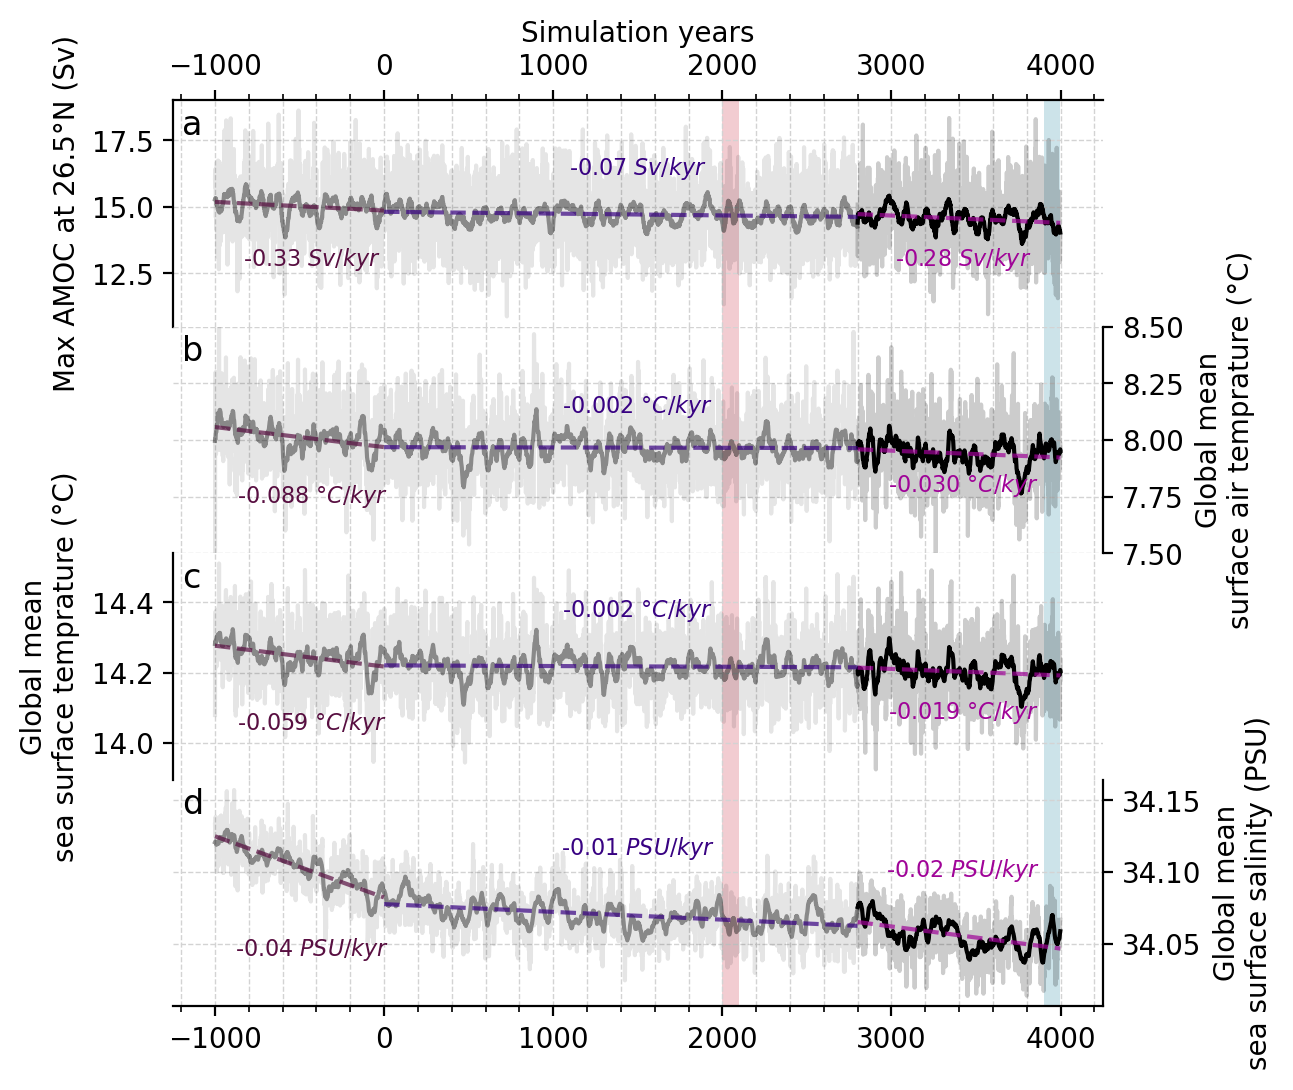

In [22]:
figMap = plt.figure(figsize=(6, 6), dpi=200)

gs = gridspec.GridSpec(nrows=4, ncols=1, hspace=0)
axAMOC = figMap.add_subplot(gs[0],facecolor='None')
axSAT = figMap.add_subplot(gs[1],facecolor='None', sharex=axAMOC)
axSST = figMap.add_subplot(gs[2],facecolor='None', sharex=axAMOC)
axSSS = figMap.add_subplot(gs[3],facecolor='None', sharex=axAMOC)

axAMOC.plot(amoc['xoupa'].processed_time(-1000)[:smooth_date['xoupa']], amoc['xoupa'].values()[:smooth_date['xoupa']], color="xkcd:black", linestyle="-", alpha=0.1)
axAMOC.plot(amoc['xoupa'].processed_time(-1000)[smooth_date['xoupa']:], amoc['xoupa'].values()[smooth_date['xoupa']:], color="xkcd:black", linestyle="-", alpha=0.2)
axAMOC.plot(amoc['xoupa'].processed_time(-1000)[:smooth_date['xoupa']], util.rmean(amoc['xoupa'].values()[:smooth_date['xoupa']], 30), alpha=0.4, color="xkcd:black", linestyle="-")
axAMOC.plot(amoc['xoupa'].processed_time(-1000)[smooth_date['xoupa']:], util.rmean(amoc['xoupa'].values()[smooth_date['xoupa']:], 30), alpha=1, color="xkcd:black", linestyle="-")

axAMOC.plot(amoc['xoupa'].processed_time(-1000)[:1000], 
            [lreg_amoc_spin[0]*i + lreg_amoc_spin[1] for i in amoc['xoupa'].processed_time(-1000)[:1000]], alpha=0.7, color='xkcd:plum', linestyle="--")
axAMOC.annotate(fr"{lreg_amoc_spin[0]*1000:.2f} $Sv/kyr$",
                xy=(0.15, 0.3), ha='center', va='center', xycoords='axes fraction', rotation=0, size=8, color="xkcd:plum")
axAMOC.plot(amoc['xoupa'].processed_time(-1000)[1000:smooth_date['xoupa']], 
            [lreg_amoc_raw[0]*i + lreg_amoc_raw[1] for i in amoc['xoupa'].processed_time(-1000)[1000:smooth_date['xoupa']]], alpha=0.7, color='xkcd:indigo', linestyle="--")
axAMOC.annotate(fr"{lreg_amoc_raw[0]*1000:.2f} $Sv/kyr$",
                xy=(0.5, 0.7), ha='center', va='center', xycoords='axes fraction', rotation=0, size=8, color="xkcd:indigo")
axAMOC.plot(amoc['xoupa'].processed_time(-1000)[smooth_date['xoupa']:], 
            [lreg_amoc_smooth[0]*i + lreg_amoc_smooth[1] for i in amoc['xoupa'].processed_time(-1000)[smooth_date['xoupa']:]], alpha=0.7, color='xkcd:barney purple', linestyle="--")
axAMOC.annotate(fr"{lreg_amoc_smooth[0]*1000:.2f} $Sv/kyr$",
                xy=(0.85, 0.3), ha='center', va='center', xycoords='axes fraction', rotation=0, size=8, color="xkcd:barney purple")

axAMOC.axvspan(spans['start_smooth']-1000, spans['end_smooth']-1000, color='xkcd:sea blue', linewidth=0, alpha=0.2)
axAMOC.axvspan(spans['start_raw']-1000, spans['end_raw']-1000, color='xkcd:scarlet', linewidth=0, alpha=0.2)
axAMOC.set_ylabel('Max AMOC at 26.5°N (Sv)')
axAMOC.set_xlabel('Simulation years')
axAMOC.spines['right'].set_visible(False)
axAMOC.spines['bottom'].set_visible(False)
axAMOC.yaxis.set_ticks_position('left')
axAMOC.yaxis.set_label_position('left')
axAMOC.xaxis.set_ticks_position('top')
axAMOC.xaxis.set_label_position('top')
axAMOC.xaxis.set_minor_locator(AutoMinorLocator())
axAMOC.grid(which = "both", color='lightgrey', linestyle='--', linewidth=0.5)


axSAT.plot(sat['xoupa'].processed_time(-1000)[:smooth_date['xoupa']], sat['xoupa'].values()[:smooth_date['xoupa']], color="xkcd:black", linestyle="-", alpha=0.1)
axSAT.plot(sat['xoupa'].processed_time(-1000)[smooth_date['xoupa']:], sat['xoupa'].values()[smooth_date['xoupa']:], color="xkcd:black", linestyle="-", alpha=0.2)
axSAT.plot(sat['xoupa'].processed_time(-1000)[:smooth_date['xoupa']], util.rmean(sat['xoupa'].values()[:smooth_date['xoupa']], 30), alpha=0.4, color="xkcd:black", linestyle="-")
axSAT.plot(sat['xoupa'].processed_time(-1000)[smooth_date['xoupa']:], util.rmean(sat['xoupa'].values()[smooth_date['xoupa']:], 30), alpha=1, color="xkcd:black", linestyle="-")

axSAT.plot(sat['xoupa'].processed_time(-1000)[:1000], 
            [lreg_sat_spin[0]*i + lreg_sat_spin[1] for i in sat['xoupa'].processed_time(-1000)[:1000]], alpha=0.7, color='xkcd:plum', linestyle="--")
axSAT.annotate(fr"{lreg_sat_spin[0]*1000:.3f} $°C/kyr$",
                xy=(0.15, 0.25), ha='center', va='center', xycoords='axes fraction', rotation=0, size=8, color="xkcd:plum")
axSAT.plot(sat['xoupa'].processed_time(-1000)[1000:smooth_date['xoupa']], 
            [lreg_sat_raw[0]*i + lreg_sat_raw[1] for i in sat['xoupa'].processed_time(-1000)[1000:smooth_date['xoupa']]], alpha=0.7, color='xkcd:indigo', linestyle="--")
axSAT.annotate(fr"{lreg_sat_raw[0]*1000:.3f} $°C/kyr$",
                xy=(0.5, 0.65), ha='center', va='center', xycoords='axes fraction', rotation=0, size=8, color="xkcd:indigo")
axSAT.plot(sat['xoupa'].processed_time(-1000)[smooth_date['xoupa']:], 
            [lreg_sat_smooth[0]*i + lreg_sat_smooth[1] for i in sat['xoupa'].processed_time(-1000)[smooth_date['xoupa']:]], alpha=0.7, color='xkcd:barney purple', linestyle="--")
axSAT.annotate(fr"{lreg_sat_smooth[0]*1000:.3f} $°C/kyr$",
                xy=(0.85, 0.3), ha='center', va='center', xycoords='axes fraction', rotation=0, size=8, color="xkcd:barney purple")

axSAT.axvspan(spans['start_smooth']-1000, spans['end_smooth']-1000, color='xkcd:sea blue', linewidth=0, alpha=0.2)
axSAT.axvspan(spans['start_raw']-1000, spans['end_raw']-1000, color='xkcd:scarlet', linewidth=0, alpha=0.2)
axSAT.set_ylabel('Global mean\nsurface air temprature (°C)')
axSAT.spines['left'].set_visible(False)
axSAT.spines['bottom'].set_visible(False)
axSAT.spines['top'].set_visible(False)
axSAT.yaxis.set_ticks_position('right')
axSAT.yaxis.set_label_position('right')
axSAT.set_ylim([7.5,8.5])
axSAT.tick_params(axis='x', colors='None', which='both')
axSAT.xaxis.set_minor_locator(AutoMinorLocator())
axSAT.grid(which = "both", color='lightgrey', linestyle='--', linewidth=0.5)

axSST.plot(sst['xoupa'].processed_time(-1000)[:smooth_date['xoupa']], sst['xoupa'].values()[:smooth_date['xoupa']], color="xkcd:black", linestyle="-", alpha=0.1)
axSST.plot(sst['xoupa'].processed_time(-1000)[smooth_date['xoupa']:], sst['xoupa'].values()[smooth_date['xoupa']:], color="xkcd:black", linestyle="-", alpha=0.2)
axSST.plot(sst['xoupa'].processed_time(-1000)[:smooth_date['xoupa']], util.rmean(sst['xoupa'].values()[:smooth_date['xoupa']], 30), alpha=0.4, color="xkcd:black", linestyle="-")
axSST.plot(sst['xoupa'].processed_time(-1000)[smooth_date['xoupa']:], util.rmean(sst['xoupa'].values()[smooth_date['xoupa']:], 30), alpha=1, color="xkcd:black", linestyle="-")
axSST.axvspan(spans['start_smooth']-1000, spans['end_smooth']-1000, color='xkcd:sea blue', linewidth=0, alpha=0.2)
axSST.axvspan(spans['start_raw']-1000, spans['end_raw']-1000, color='xkcd:scarlet', linewidth=0, alpha=0.2)

axSST.plot(sst['xoupa'].processed_time(-1000)[:1000], 
            [lreg_sst_spin[0]*i + lreg_sst_spin[1] for i in sst['xoupa'].processed_time(-1000)[:1000]], alpha=0.7, color='xkcd:plum', linestyle="--")
axSST.annotate(fr"{lreg_sst_spin[0]*1000:.3f} $°C/kyr$",
                xy=(0.15, 0.25), ha='center', va='center', xycoords='axes fraction', rotation=0, size=8, color="xkcd:plum")
axSST.plot(sst['xoupa'].processed_time(-1000)[1000:smooth_date['xoupa']], 
            [lreg_sst_raw[0]*i + lreg_sst_raw[1] for i in sst['xoupa'].processed_time(-1000)[1000:smooth_date['xoupa']]], alpha=0.7, color='xkcd:indigo', linestyle="--")
axSST.annotate(fr"{lreg_sst_raw[0]*1000:.3f} $°C/kyr$",
                xy=(0.5, 0.75), ha='center', va='center', xycoords='axes fraction', rotation=0, size=8, color="xkcd:indigo")
axSST.plot(sst['xoupa'].processed_time(-1000)[smooth_date['xoupa']:], 
            [lreg_sst_smooth[0]*i + lreg_sst_smooth[1] for i in sst['xoupa'].processed_time(-1000)[smooth_date['xoupa']:]], alpha=0.7, color='xkcd:barney purple', linestyle="--")
axSST.annotate(fr"{lreg_sst_smooth[0]*1000:.3f} $°C/kyr$",
                xy=(0.85, 0.3), ha='center', va='center', xycoords='axes fraction', rotation=0, size=8, color="xkcd:barney purple")

axSST.set_ylabel('Global mean\nsea surface temprature (°C)')
axSST.spines['right'].set_visible(False)
axSST.spines['bottom'].set_visible(False)
axSST.spines['top'].set_visible(False)
axSST.yaxis.set_ticks_position('left')
axSST.yaxis.set_label_position('left')
axSST.tick_params(axis='x', colors='None', which='both')
axSST.xaxis.set_minor_locator(AutoMinorLocator())
axSST.grid(which = "both", color='lightgrey', linestyle='--', linewidth=0.5)

axSSS.plot(sss['xoupa'].processed_time(-1000)[:smooth_date['xoupa']], sss['xoupa'].values()[:smooth_date['xoupa']], color="xkcd:black", linestyle="-", alpha=0.1)
axSSS.plot(sss['xoupa'].processed_time(-1000)[smooth_date['xoupa']:], sss['xoupa'].values()[smooth_date['xoupa']:], color="xkcd:black", linestyle="-", alpha=0.2)
axSSS.plot(sss['xoupa'].processed_time(-1000)[:smooth_date['xoupa']], util.rmean(sss['xoupa'].values()[:smooth_date['xoupa']], 30), alpha=0.4, color="xkcd:black", linestyle="-")
axSSS.plot(sss['xoupa'].processed_time(-1000)[smooth_date['xoupa']:], util.rmean(sss['xoupa'].values()[smooth_date['xoupa']:], 30), alpha=1, color="xkcd:black", linestyle="-")

axSSS.plot(sss['xoupa'].processed_time(-1000)[:1000], 
            [lreg_sss_spin[0]*i + lreg_sss_spin[1] for i in sss['xoupa'].processed_time(-1000)[:1000]], alpha=0.7, color='xkcd:plum', linestyle="--")
axSSS.annotate(fr"{lreg_sss_spin[0]*1000:.2f} $PSU/kyr$",
                xy=(0.15, 0.25), ha='center', va='center', xycoords='axes fraction', rotation=0, size=8, color="xkcd:plum")
axSSS.plot(sss['xoupa'].processed_time(-1000)[1000:smooth_date['xoupa']], 
            [lreg_sss_raw[0]*i + lreg_sss_raw[1] for i in sss['xoupa'].processed_time(-1000)[1000:smooth_date['xoupa']]], alpha=0.7, color='xkcd:indigo', linestyle="--")
axSSS.annotate(fr"{lreg_sss_raw[0]*1000:.2f} $PSU/kyr$",
                xy=(0.5, 0.7), ha='center', va='center', xycoords='axes fraction', rotation=0, size=8, color="xkcd:indigo")
axSSS.plot(sss['xoupa'].processed_time(-1000)[smooth_date['xoupa']:], 
            [lreg_sss_smooth[0]*i + lreg_sss_smooth[1] for i in sss['xoupa'].processed_time(-1000)[smooth_date['xoupa']:]], alpha=0.7, color='xkcd:barney purple', linestyle="--")
axSSS.annotate(fr"{lreg_sss_smooth[0]*1000:.2f} $PSU/kyr$",
                xy=(0.85, 0.6), ha='center', va='center', xycoords='axes fraction', rotation=0, size=8, color="xkcd:barney purple")

axSSS.axvspan(spans['start_smooth']-1000, spans['end_smooth']-1000, color='xkcd:sea blue', linewidth=0, alpha=0.2)
axSSS.axvspan(spans['start_raw']-1000, spans['end_raw']-1000, color='xkcd:scarlet', linewidth=0, alpha=0.2)
axSSS.set_ylabel('Global mean\nsea surface salinity (PSU)')
axSSS.spines['left'].set_visible(False)
axSSS.spines['top'].set_visible(False)
axSSS.yaxis.set_ticks_position('right')
axSSS.yaxis.set_label_position('right')
axSSS.xaxis.set_minor_locator(AutoMinorLocator())
axSSS.grid(which = "both", color='lightgrey', linestyle='--', linewidth=0.5)

axAMOC.annotate('a', xy=(0.01,0.85), xycoords='axes fraction', size=12)
axSAT.annotate('b', xy=(0.01,0.85), xycoords='axes fraction', size=12)
axSST.annotate('c', xy=(0.01,0.85), xycoords='axes fraction', size=12)
axSSS.annotate('d', xy=(0.01,0.85), xycoords='axes fraction', size=12)

## Composite modes definition

### Figure X - Picking AMOC and NGRIP modes

In [34]:
## Functions for method 5

def identify_min(signal):
    dsignal, lim = np.diff(signal), np.min(signal) + 1*(np.max(signal) - np.min(signal))/3
    index_min=[]

    i = 0
    while i<len(signal)-2:
        if np.sign(dsignal[i])!=np.sign(dsignal[i+1]) and dsignal[i]<0 and signal[i]<lim:
            index_min.append(i)
            i+=500
        else:
            i+=1
    return index_min
            
def identify_max(signal):
    dsignal, lim = np.diff(signal), np.min(signal) + 2*(np.max(signal) - np.min(signal))/3
    index_min=[]

    i = 0
    while i<len(signal)-2:
        if np.sign(dsignal[i])!=np.sign(dsignal[i+1]) and dsignal[i]>0 and signal[i]>lim:
            index_min.append(i)
            i+=500
        else:
            i+=1
    return index_min

def span_from_index(signal, indexes, span_size=50):
    array = np.empty(len(signal))
    array[:] = np.NaN
    for index in indexes:
        if index+span_size//2<len(signal) and index-span_size//2>=0:
            array[index-span_size//2:index+span_size//2] = signal[index-span_size//2:index+span_size//2]
    return array

In [32]:
ngrip, amoc = {}, {}
amocv, ngripv, n, time = {}, {}, {}, {}

for expt in ['tfgbi', 'tfgbj', 'xoupf', 'xouph']:
    ngrip[expt] = hcm3.SATATS(expt, chunks=10).sat(mode_lat="value", value_lat=75, mode_lon="value", value_lon = 318)
    amoc[expt] = hcm3.MERIDATS(expt, chunks=10).atlantic(mode_lat="value", value_lat=26.5, mode_z="max")

ngrip['xoupl'] = hcm3.SATATS('tfgbr', end_year=3999, chunks=10).concat(hcm3.SATATS('xoupl', chunks=10)).sat(mode_lat="value", value_lat=75, mode_lon="value", value_lon = 318)
amoc['xoupl'] = hcm3.MERIDATS('tfgbr', end_year=3999, chunks=10).concat(hcm3.MERIDATS('xoupl', chunks=10)).atlantic(mode_lat="value", value_lat=26.5, mode_z="max")

amoc['xoupd'] = hcm3.MERIDATS('tfgbd', end_year=4060, chunks=10).concat(hcm3.MERIDATS('xoupd', chunks=10)).atlantic(mode_lat="value", value_lat=26.5, mode_z="max")
ngrip['xoupd'] = hcm3.SATATS('tfgbd', end_year=4060, chunks=10).concat(hcm3.SATATS('xoupd', chunks=10)).sat(mode_lat="value", value_lat=75, mode_lon="value", value_lon = 318)

for expt in ['xoupd', 'tfgbi', 'tfgbj', 'xoupl', 'xoupf', 'xouph']:
    n[expt] = min(len(amoc[expt].t), len(ngrip[expt].t))
    amocv[expt] = util.rmean(amoc[expt].values(), 30)[:n[expt]]
    ngripv[expt] = util.rmean(ngrip[expt].values(), 30)[:n[expt]]
    time[expt] = amoc[expt].processed_time(start_dates[expt])[:n[expt]]

__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : tfgbi between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ New longitude value : 318.75
____ New latitude value : 75.0
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : tfgbi between years 1001 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ New latitude value : 26.25
____ Processing z: max
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : tfgbj between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
__

In [33]:
psd, fq, harm, fc, = {}, {}, {}, {}
ngripf, amocf = {}, {}

filt = util.ButterLowPass(order=1, fc=2*10**-3, fs=1, mult=2)

for expt in ['tfgbi', 'xoupl', 'xoupf', 'tfgbj', 'xoupd', 'xouph']:
    psd[expt], fq[expt] = util.psd(ngrip[expt].values(), fs=1, scale_by_freq=True)
    harm[expt] = np.where(fq[expt]<=10**-1)
    fc[expt] = util.fundamental_fq(psd[expt], fq[expt])
    
    ngripf[expt] = filt.process(ngrip[expt].values())[:n[expt]]  
    amocf[expt] = filt.process(amoc[expt].values())[:n[expt]]  

In [43]:
amocc, amocw = {}, {}
ngripc, ngripw, = {}, {}
clim, wlim = {}, {}
imin_amoc, imax_amoc = {}, {}

for method in ['Method 1', 'Method 1b', 'Method 2', 'Method 3', 'Method 4', 'Method 5']:
    clim[method], wlim[method] = {}, {}

for expt in ['xoupd', 'tfgbi', 'tfgbj', 'xoupl', 'xoupf', 'xouph']:
    
    clim['Method 1'][expt] = np.min(amocv[expt]) + 1*(np.max(amocv[expt]) - np.min(amocv[expt]))/3
    wlim['Method 1'][expt] = np.min(amocv[expt]) + 2*(np.max(amocv[expt]) - np.min(amocv[expt]))/3

    clim['Method 1b'][expt] = np.min(amocf[expt]) + 1*(np.max(amocf[expt]) - np.min(amocf[expt]))/3
    wlim['Method 1b'][expt] = np.min(amocf[expt]) + 2*(np.max(amocf[expt]) - np.min(amocf[expt]))/3

    clim['Method 2'][expt] = np.min(ngripv[expt]) + 1*(np.max(ngripv[expt]) - np.min(ngripv[expt]))/3
    wlim['Method 2'][expt] = np.min(ngripv[expt]) + 2*(np.max(ngripv[expt]) - np.min(ngripv[expt]))/3

    if expt not in ['xoupd', 'xouph']:
        clim['Method 3'][expt] = np.min(amocv[expt][1000:]) + 1*(np.max(amocv[expt][1000:]) - np.min(amocv[expt][1000:]))/4
        wlim['Method 3'][expt] = np.min(amocv[expt][1000:]) + 3*(np.max(amocv[expt][1000:]) - np.min(amocv[expt][1000:]))/4
    else:
        clim['Method 3'][expt] = np.min(amocv[expt]) + 1*(np.max(amocv[expt]) - np.min(amocv[expt]))/4
        wlim['Method 3'][expt] = np.min(amocv[expt]) + 3*(np.max(amocv[expt]) - np.min(amocv[expt]))/4

    clim['Method 4'] = {'xoupd':14, 'xouph':12, 'tfgbi':8, 'tfgbj':8, 'xoupl':8, 'xoupf':8}
    wlim['Method 4'] = {'xoupd':14.5, 'xouph':14.5, 'tfgbi':15, 'tfgbj':15, 'xoupl':16, 'xoupf':13.5}

    imin_amoc[expt] = identify_min(amocf[expt])
    imax_amoc[expt] = identify_max(amocf[expt])


for method in ['Method 1', 'Method 1b', 'Method 2', 'Method 3', 'Method 4', 'Method 5']:
    amocc[method], amocw[method] = {}, {}
    ngripc[method], ngripw[method] = {}, {}
    
    for expt in ['xoupd', 'tfgbi', 'tfgbj', 'xoupl', 'xoupf', 'xouph']:

        print(f"Processing {method} - {expt}")

        if method in ['Method 1', 'Method 3', 'Method 4']:
            amocc[method][expt] = np.where(amocv[expt]<=clim[method][expt], amocv[expt], np.nan)
            amocw[method][expt] = np.where(amocv[expt]>=wlim[method][expt], amocv[expt], np.nan)
            ngripc[method][expt] = np.where(amocv[expt]<=clim[method][expt], ngripv[expt], np.nan)
            ngripw[method][expt] = np.where(amocv[expt]>=wlim[method][expt], ngripv[expt], np.nan)
        
        elif method=='Method 1b':
            amocc[method][expt] = np.where(amocf[expt]<=clim[method][expt], amocf[expt], np.nan)
            amocw[method][expt] = np.where(amocf[expt]>=wlim[method][expt], amocf[expt], np.nan)
            ngripc[method][expt] = np.where(amocf[expt]<=clim[method][expt], ngripf[expt], np.nan)
            ngripw[method][expt] = np.where(amocf[expt]>=wlim[method][expt], ngripf[expt], np.nan)

        elif method=='Method 2':
            ngripc[method][expt] = np.where(ngripv[expt]<=clim[method][expt], ngripv[expt], np.nan)
            ngripw[method][expt] = np.where(ngripv[expt]>=wlim[method][expt], ngripv[expt], np.nan)
            amocc[method][expt] = np.where(ngripv[expt]<=clim[method][expt], amocv[expt], np.nan)
            amocw[method][expt] = np.where(ngripv[expt]>=wlim[method][expt], amocv[expt], np.nan)
   
        elif method=='Method 5':
            amocc[method][expt] = span_from_index(amocf[expt], imin_amoc[expt], span_size=150)
            ngripc[method][expt] = span_from_index(ngripf[expt], imin_amoc[expt], span_size=150)
            amocw[method][expt] = span_from_index(amocf[expt], imax_amoc[expt], span_size=150)
            ngripw[method][expt] = span_from_index(ngripf[expt], imax_amoc[expt], span_size=150)

Processing Method 1 - xoupd
Processing Method 1 - tfgbi
Processing Method 1 - tfgbj
Processing Method 1 - xoupl
Processing Method 1 - xoupf
Processing Method 1 - xouph
Processing Method 1b - xoupd
Processing Method 1b - tfgbi
Processing Method 1b - tfgbj
Processing Method 1b - xoupl
Processing Method 1b - xoupf
Processing Method 1b - xouph
Processing Method 2 - xoupd
Processing Method 2 - tfgbi
Processing Method 2 - tfgbj
Processing Method 2 - xoupl
Processing Method 2 - xoupf
Processing Method 2 - xouph
Processing Method 3 - xoupd
Processing Method 3 - tfgbi
Processing Method 3 - tfgbj
Processing Method 3 - xoupl
Processing Method 3 - xoupf
Processing Method 3 - xouph
Processing Method 4 - xoupd
Processing Method 4 - tfgbi
Processing Method 4 - tfgbj
Processing Method 4 - xoupl
Processing Method 4 - xoupf
Processing Method 4 - xouph
Processing Method 5 - xoupd
Processing Method 5 - tfgbi
Processing Method 5 - tfgbj
Processing Method 5 - xoupl
Processing Method 5 - xoupf
Processing Met

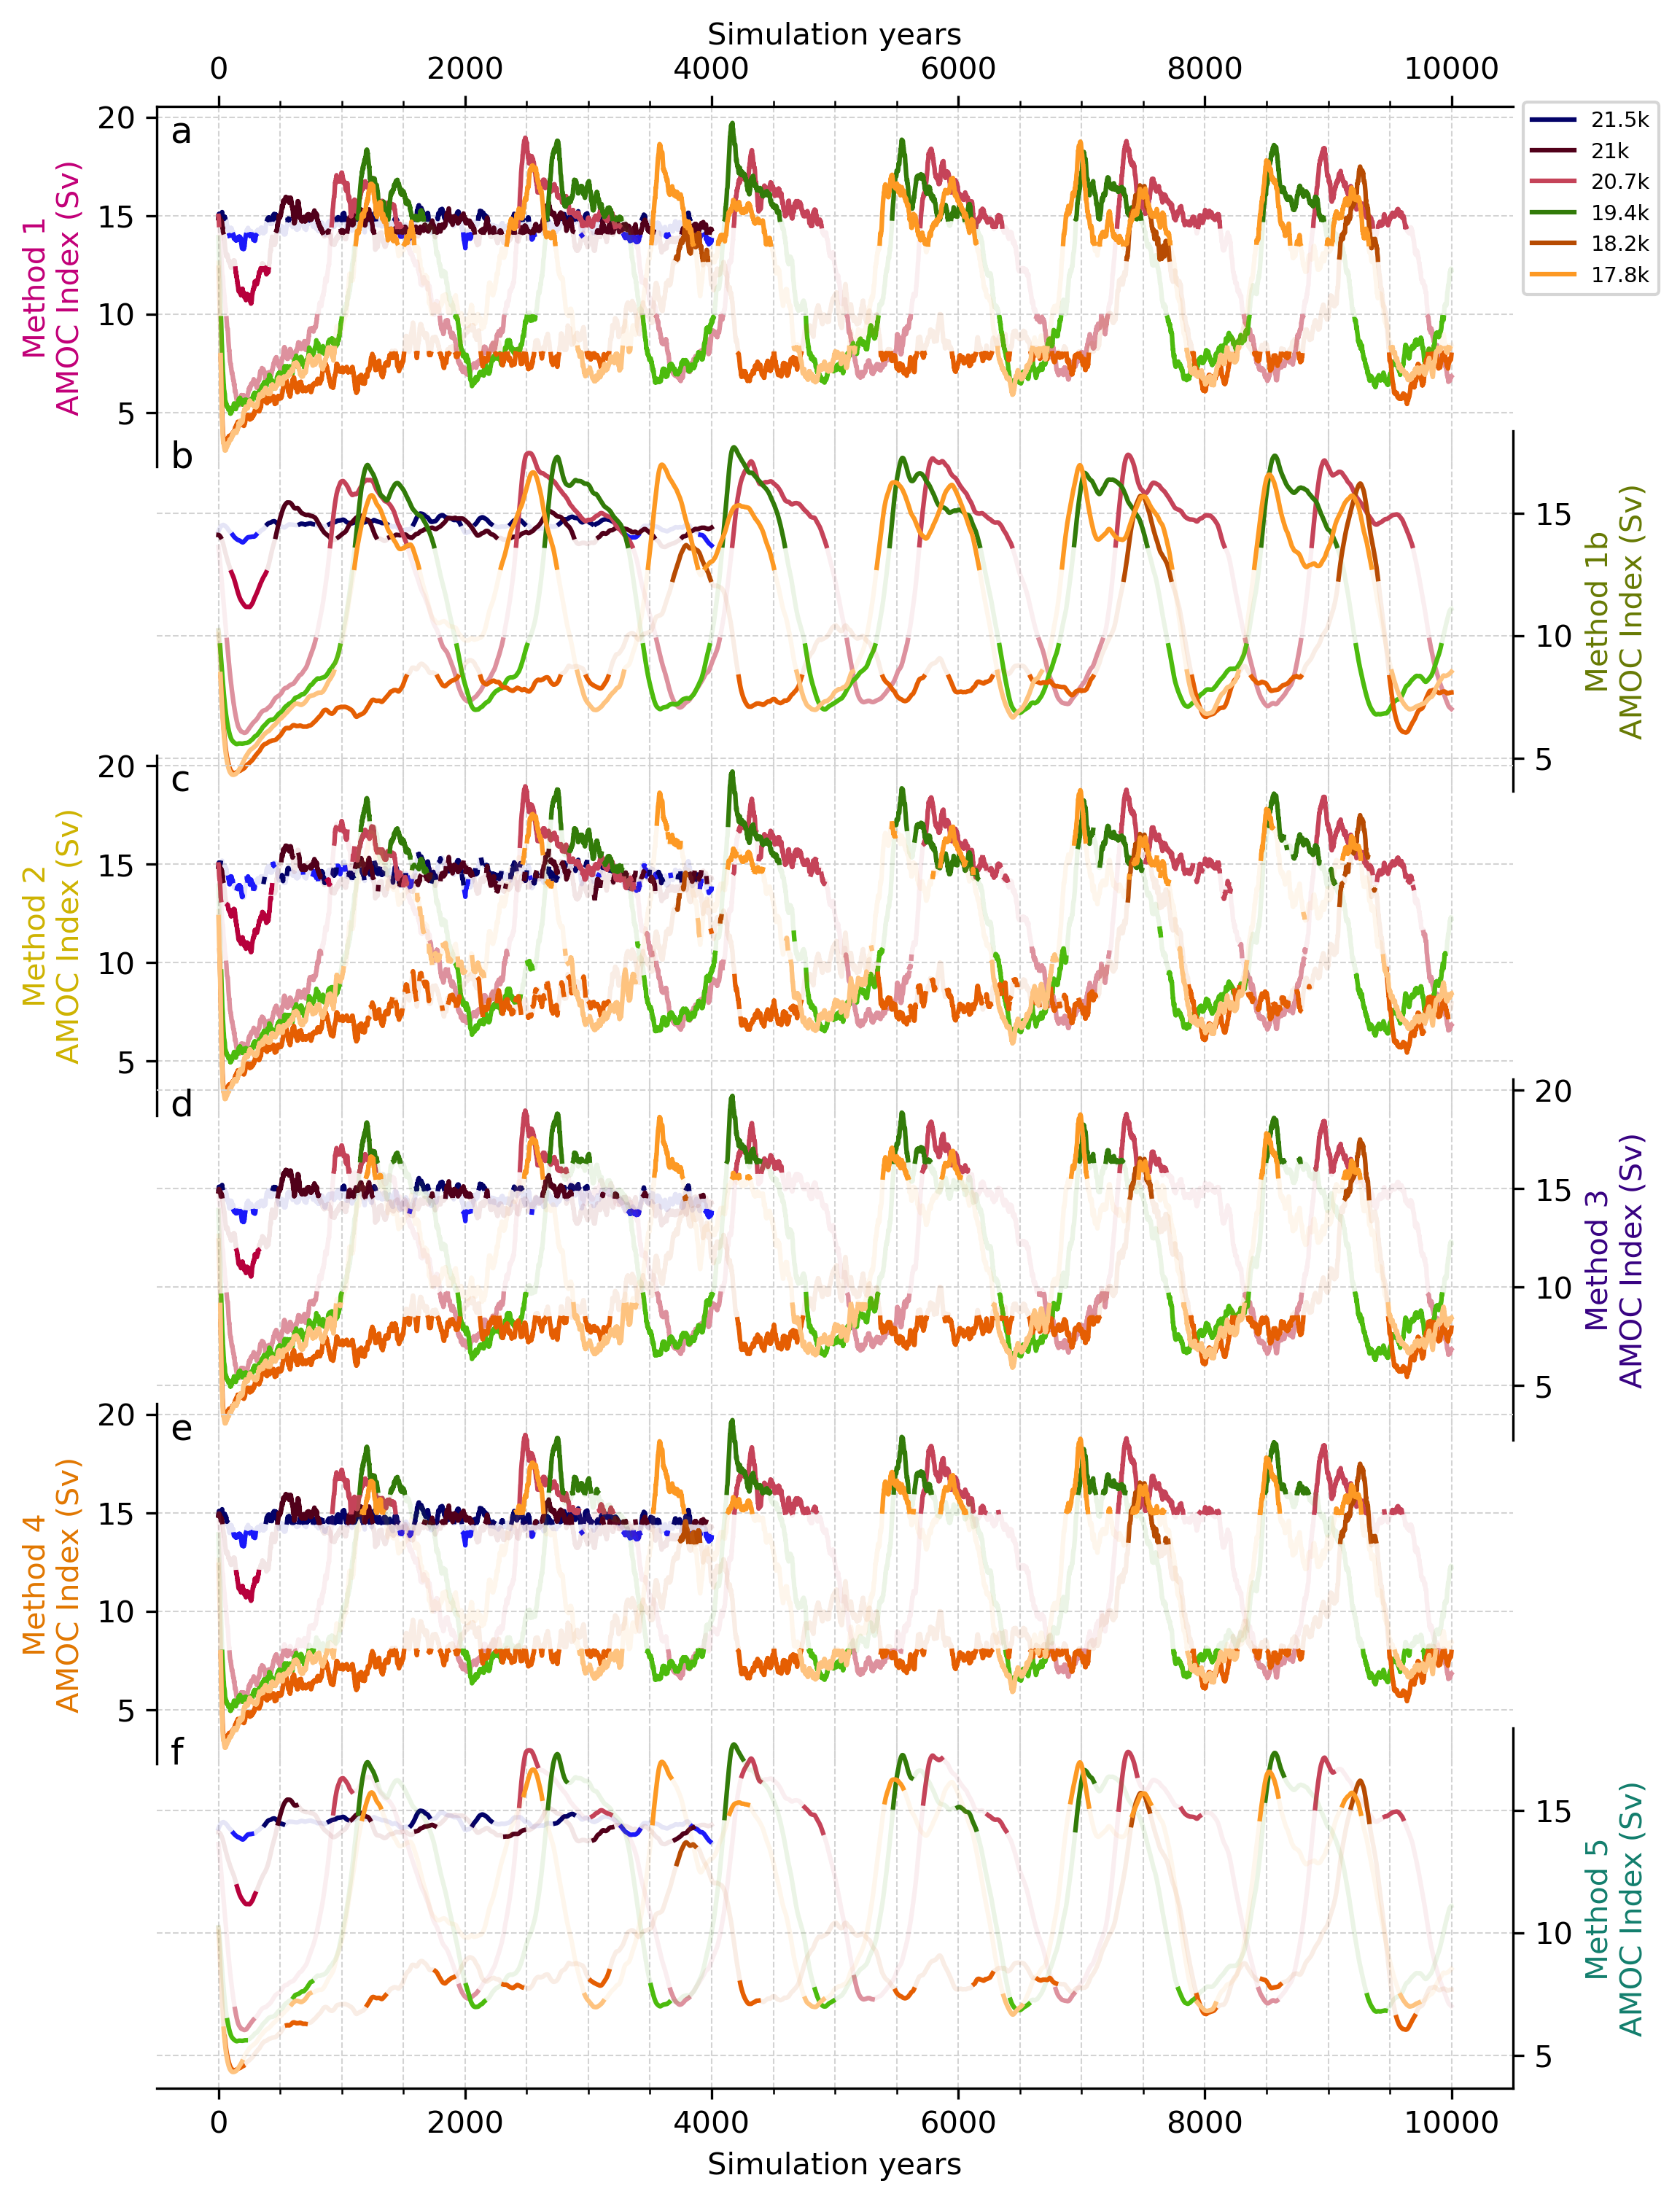

In [79]:
figMap = plt.figure(figsize=(8, 12), dpi=300, facecolor='None')

axAMOC = {}

gs = figMap.add_gridspec(nrows=6, ncols=1, hspace=-0.1)
(axAMOC['Method 1'], axAMOC['Method 1b'], axAMOC['Method 2'], axAMOC['Method 3'], axAMOC['Method 4'], axAMOC['Method 5']) = gs.subplots(
    subplot_kw={'facecolor':'None'})

letter = 'a'

for expt in ['xoupd', 'xouph', 'tfgbi', 'xoupl', 'xoupf', 'tfgbj']:
    for method in ['Method 1', 'Method 2', 'Method 3', 'Method 4']:
        axAMOC[method].plot(time[expt], amocv[expt], color=colors[expt], linestyle="-", alpha=0.1)
        axAMOC[method].plot(time[expt], amocc[method][expt], color=colors_cold[expt], linestyle="-")
        axAMOC[method].plot(time[expt], amocw[method][expt], color=colors_warm[expt], linestyle="-", 
                            label=labels[expt])
    for method in ['Method 1b', 'Method 5']:
        axAMOC[method].plot(time[expt], amocf[expt], color=colors[expt], linestyle="-", alpha=0.1)
        axAMOC[method].plot(time[expt], amocc[method][expt], color=colors_cold[expt], linestyle="-")
        axAMOC[method].plot(time[expt], amocw[method][expt], color=colors_warm[expt], linestyle="-", 
                            label=labels[expt])
    
for method in ['Method 1', 'Method 2', 'Method 4']:
    axAMOC[method].spines['right'].set_visible(False)
    axAMOC[method].spines['top'].set_visible(False)
    axAMOC[method].spines['bottom'].set_visible(False)
    
axAMOC['Method 1'].spines['top'].set_visible(True)
axAMOC['Method 1'].xaxis.set_ticks_position('top')
axAMOC['Method 1'].xaxis.set_label_position('top')
axAMOC['Method 1'].set_xlabel("Simulation years")

for method in ['Method 1b', 'Method 3', 'Method 5']:
    axAMOC[method].spines['left'].set_visible(False)
    axAMOC[method].spines['top'].set_visible(False)
    axAMOC[method].spines['bottom'].set_visible(False)
    axAMOC[method].yaxis.set_ticks_position('right')
    axAMOC[method].yaxis.set_label_position('right')

axAMOC['Method 5'].spines['bottom'].set_visible(True)
axAMOC['Method 5'].set_xlabel("Simulation years")

for method in ['Method 1b', 'Method 2', 'Method 3', 'Method 4']:
    axAMOC[method].tick_params(axis='x', colors='None', which="both")

for method in ['Method 1', 'Method 1b', 'Method 2', 'Method 3', 'Method 4', 'Method 5']:
    axAMOC[method].xaxis.set_minor_locator(AutoMinorLocator())
    axAMOC[method].grid(which = 'both', color='lightgrey', linestyle='--', linewidth=0.5)
    axAMOC[method].set_ylabel(f"{method}\nAMOC Index (Sv)", color=colors_method[method])
    axAMOC[method].annotate(letter, xy=(0.01, 0.9), xycoords='axes fraction', size=12)
    letter = chr(ord(letter)+1)
    
axAMOC['Method 1'].legend(fontsize='x-small', loc="lower left", bbox_to_anchor=(1, 0.45, 1, 1))

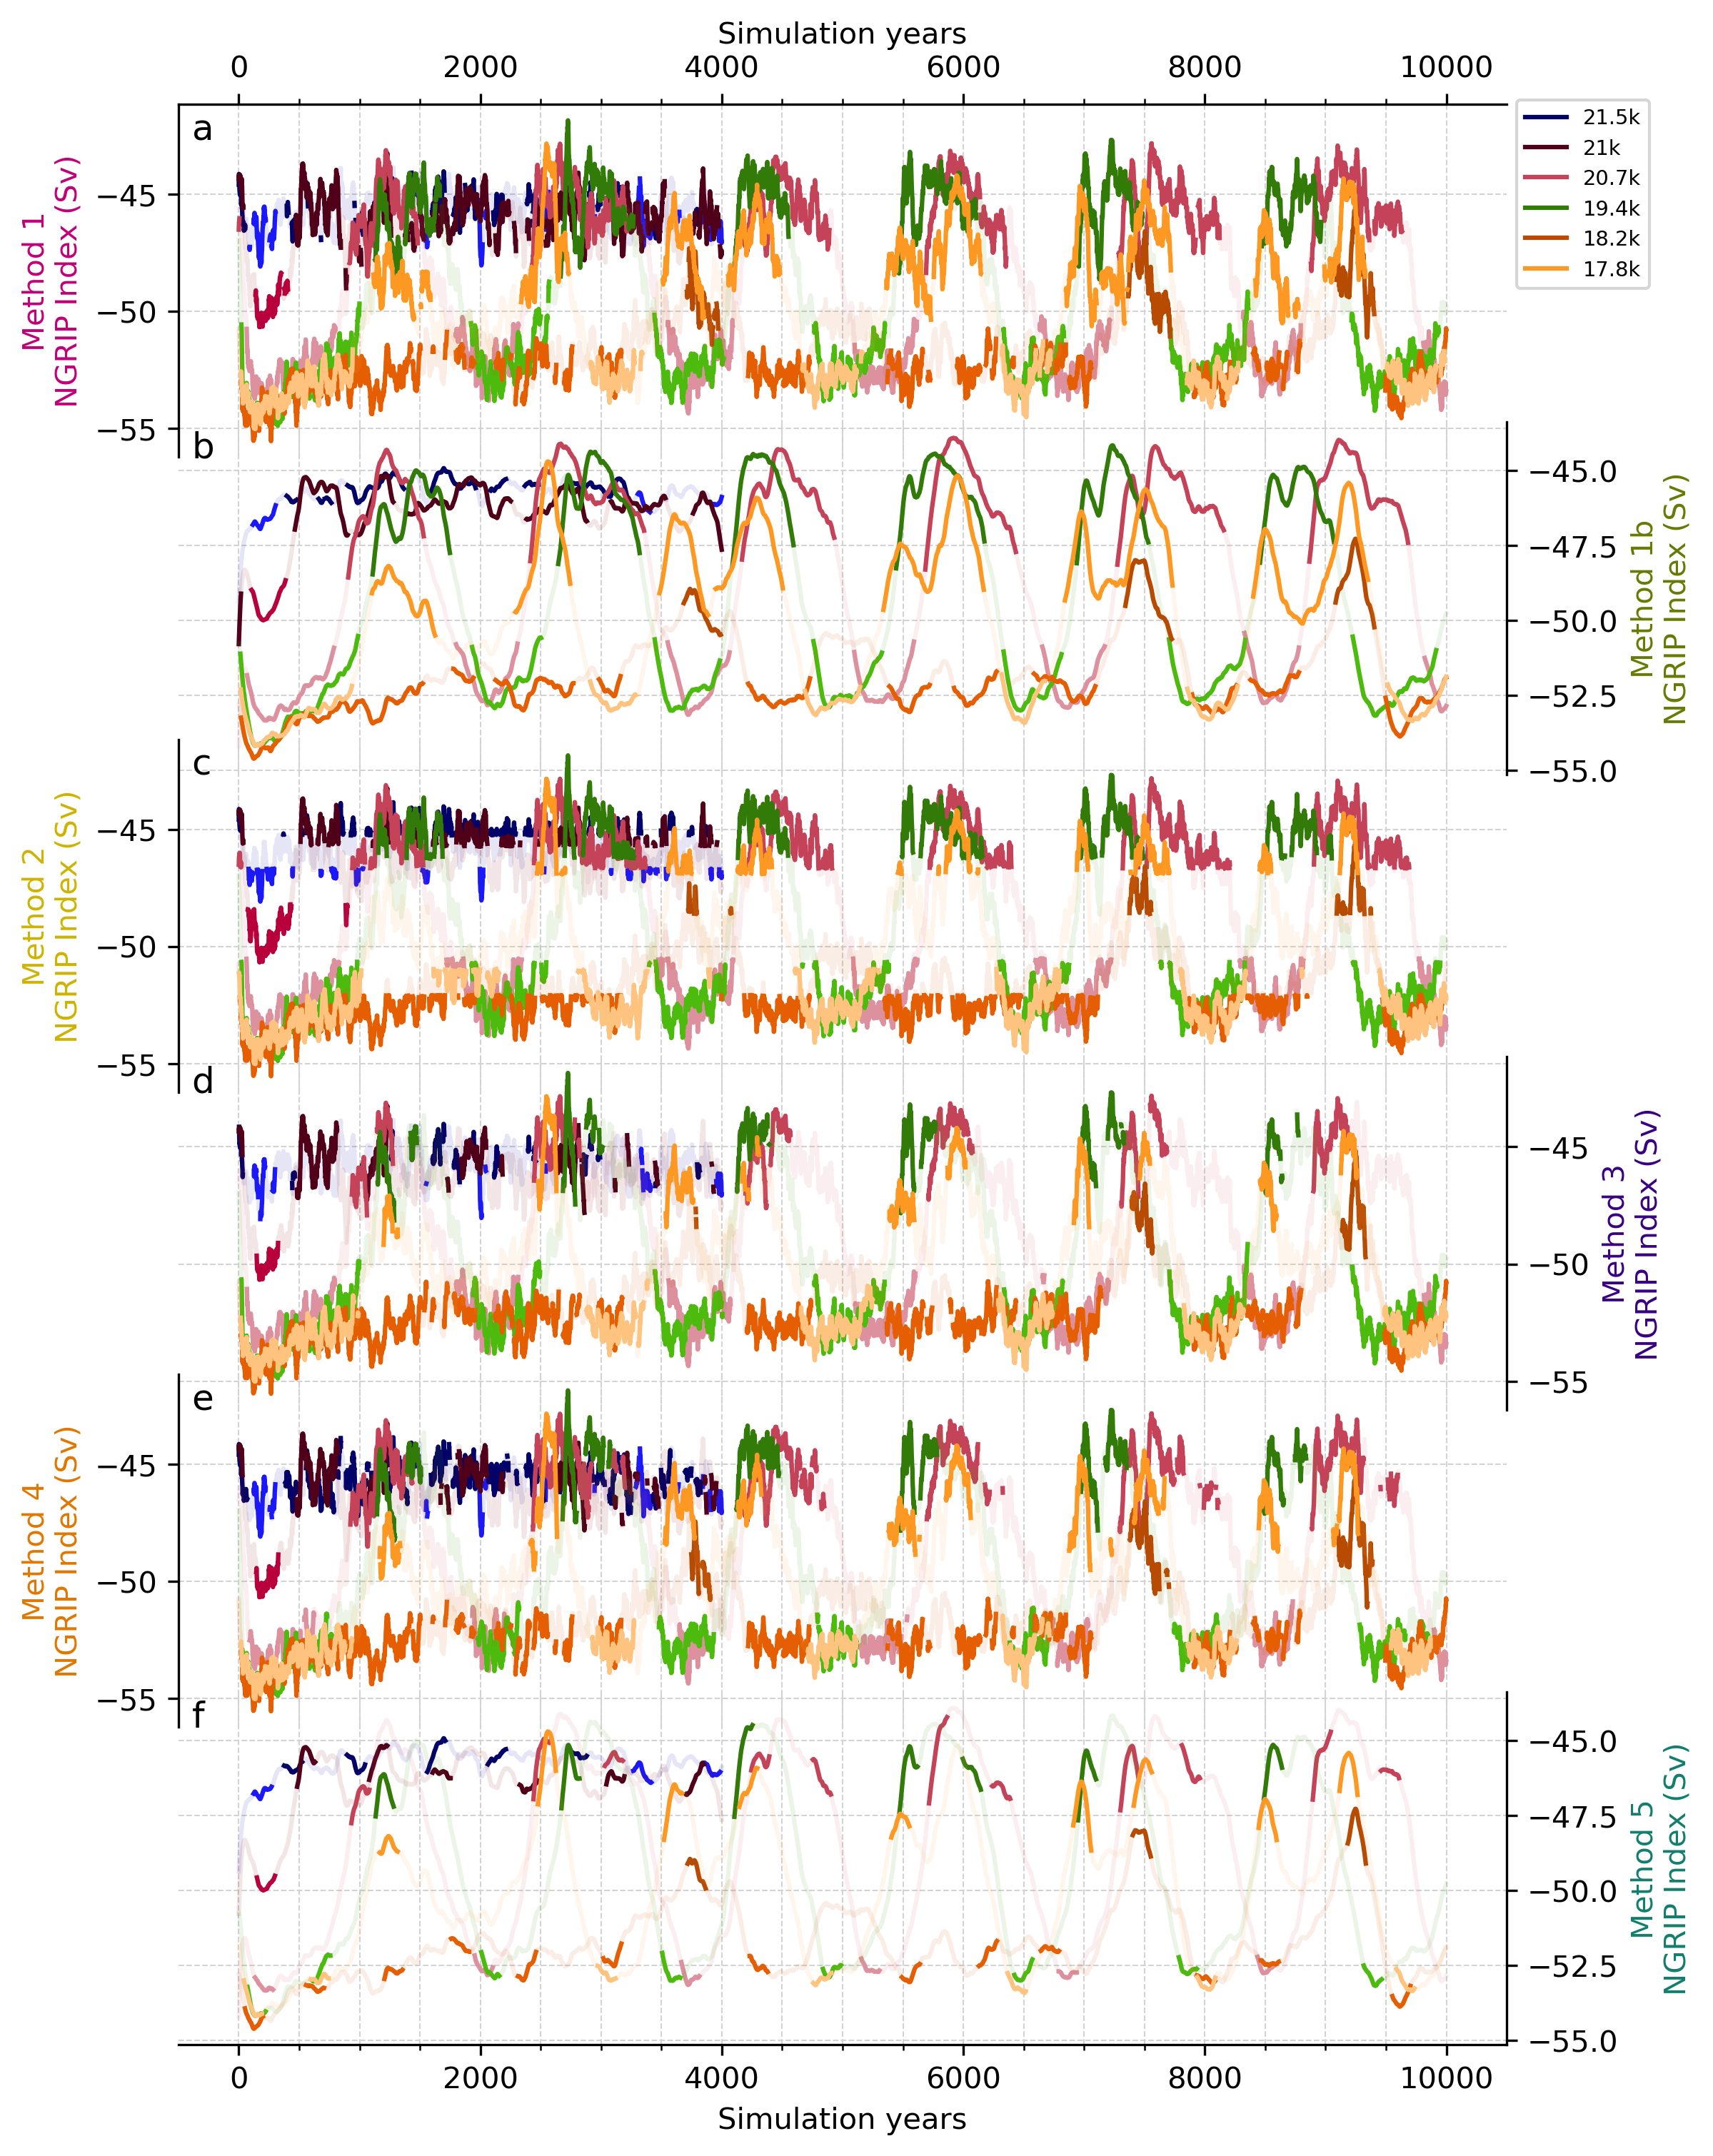

In [80]:
figMap = plt.figure(figsize=(8, 12), dpi=300, facecolor='None')

axNGRIP = {}

gs = figMap.add_gridspec(nrows=6, ncols=1, hspace=-0.1)
(axNGRIP['Method 1'], axNGRIP['Method 1b'], axNGRIP['Method 2'], axNGRIP['Method 3'], axNGRIP['Method 4'], axNGRIP['Method 5']) = gs.subplots(
    subplot_kw={'facecolor':'None'})

letter = 'a'

for expt in ['xoupd', 'xouph', 'tfgbi', 'xoupl', 'xoupf', 'tfgbj']:
    for method in ['Method 1', 'Method 2', 'Method 3', 'Method 4']:
        axNGRIP[method].plot(time[expt], ngripv[expt], color=colors[expt], linestyle="-", alpha=0.1)
        axNGRIP[method].plot(time[expt], ngripc[method][expt], color=colors_cold[expt], linestyle="-")
        axNGRIP[method].plot(time[expt], ngripw[method][expt], color=colors_warm[expt], linestyle="-", 
                            label=labels[expt])
    for method in ['Method 1b', 'Method 5']:
        axNGRIP[method].plot(time[expt], ngripf[expt], color=colors[expt], linestyle="-", alpha=0.1)
        axNGRIP[method].plot(time[expt], ngripc[method][expt], color=colors_cold[expt], linestyle="-")
        axNGRIP[method].plot(time[expt], ngripw[method][expt], color=colors_warm[expt], linestyle="-", 
                            label=labels[expt])
    
for method in ['Method 1', 'Method 2', 'Method 4']:
    axNGRIP[method].spines['right'].set_visible(False)
    axNGRIP[method].spines['top'].set_visible(False)
    axNGRIP[method].spines['bottom'].set_visible(False)

axNGRIP['Method 1'].spines['top'].set_visible(True)
axNGRIP['Method 1'].xaxis.set_ticks_position('top')
axNGRIP['Method 1'].xaxis.set_label_position('top')
axNGRIP['Method 1'].set_xlabel("Simulation years")

for method in ['Method 1b', 'Method 3', 'Method 5']:
    axNGRIP[method].spines['left'].set_visible(False)
    axNGRIP[method].spines['top'].set_visible(False)
    axNGRIP[method].spines['bottom'].set_visible(False)
    axNGRIP[method].yaxis.set_ticks_position('right')
    axNGRIP[method].yaxis.set_label_position('right')

axNGRIP['Method 5'].spines['bottom'].set_visible(True)
axNGRIP['Method 5'].set_xlabel("Simulation years")

for method in ['Method 1b', 'Method 2', 'Method 3', 'Method 4']:
    axNGRIP[method].tick_params(axis='x', colors='None', which="both")

for method in ['Method 1', 'Method 1b', 'Method 2', 'Method 3', 'Method 4', 'Method 5']:
    axNGRIP[method].xaxis.set_minor_locator(AutoMinorLocator())
    axNGRIP[method].grid(which = 'both', color='lightgrey', linestyle='--', linewidth=0.5)
    axNGRIP[method].set_ylabel(f"{method}\nNGRIP Index (Sv)", color=colors_method[method])
    axNGRIP[method].annotate(letter, xy=(0.01, 0.9), xycoords='axes fraction', size=12)
    letter = chr(ord(letter)+1)
        
axNGRIP['Method 1'].legend(fontsize='x-small', loc="lower left", bbox_to_anchor=(1, 0.45, 1, 1))

### Figure X - Methods comparison for the oscillating simulations

In [59]:
expt = 'tfgbi'
cind, wind = {}, {}

for method in ['Method 1', 'Method 1b', 'Method 2', 'Method 3', 'Method 4', 'Method 5']:
    cind[method] = np.where(~np.isnan(amocc[method][expt]))
    wind[method] = np.where(~np.isnan(amocw[method][expt]))
    
amoc, sat, sst, mld, wice, sice = {}, {}, {}, {}, {}, {}
amoc_mode, sat_mode, sst_mode, mld_mode, wice_mode, sice_mode = {}, {}, {}, {}, {}, {}

amoc_ref = hcm3.MERIDATS('xoupa', chunks=10).atlantic(mode_z="max", mode_t='mean', zone=zones.Box(lat_min=-20, lat_max=80)).values()
sat_ref = hcm3.SATATS('xoupa', chunks=10).sat(mode_lon="mean", mode_t='mean', zone=plane_at).values()
sst_ref = hcm3.SSTATS('xoupa', chunks=10).sst(mode_lon="mean", mode_t='mean', zone=plane_at).values()
mld_ref = hcm3.MLDATS('xoupa', chunks=10).mld(mode_lon="mean", mode_t='mean', zone=plane_at).values()
wice_ref = hcm3.WICEATS('xoupa', chunks=10).ice_conc(mode_lon="mean", mode_t='mean', zone=plane_at).values()*100
sice_ref = hcm3.SICEATS('xoupa', chunks=10).ice_conc(mode_lon="mean", mode_t='mean', zone=plane_at).values()*100

amoc = hcm3.MERIDATS(expt, chunks=10).atlantic(mode_z="max", zone=zones.Box(lat_min=-20, lat_max=80))
sat = hcm3.SATATS(expt, chunks=10).sat(mode_lon="mean", zone=plane_at)
sst = hcm3.SSTATS(expt, chunks=10).sst(mode_lon="mean", zone=plane_at)
mld = hcm3.MLDATS(expt, chunks=10).mld(mode_lon="mean", zone=plane_at)
wice = hcm3.WICEATS(expt, chunks=10).ice_conc(mode_lon="mean", zone=plane_at)
sice = hcm3.SICEATS(expt, chunks=10).ice_conc(mode_lon="mean", zone=plane_at)


for method in ['Method 1', 'Method 1b', 'Method 2', 'Method 3', 'Method 4', 'Method 5']:
    amoc_mode[method] = {}
    amoc_mode[method]['Cold'] = np.nanmean(amoc.values()[cind[method]], axis=0)
    amoc_mode[method]['Warm'] = np.nanmean(amoc.values()[wind[method]], axis=0)
    
    sst_mode[method] = {}
    sst_mode[method]['Cold'] = np.nanmean(sst.values()[cind[method]], axis=0)
    sst_mode[method]['Warm'] = np.nanmean(sst.values()[wind[method]], axis=0)

    sat_mode[method] = {}
    sat_mode[method]['Cold'] = np.nanmean(sat.values()[cind[method]], axis=0)
    sat_mode[method]['Warm'] = np.nanmean(sat.values()[wind[method]], axis=0)

    mld_mode[method] = {}
    mld_mode[method]['Cold'] = np.nanmean(mld.values()[cind[method]], axis=0)
    mld_mode[method]['Warm'] = np.nanmean(mld.values()[wind[method]], axis=0)

    wice_mode[method] = {}
    wice_mode[method]['Cold'] = np.nanmean(wice.values()[cind[method]], axis=0)*100
    wice_mode[method]['Warm'] = np.nanmean(wice.values()[wind[method]], axis=0)*100

    sice_mode[method] = {}
    sice_mode[method]['Cold'] = np.nanmean(sice.values()[cind[method]], axis=0)*100
    sice_mode[method]['Warm'] = np.nanmean(sice.values()[wind[method]], axis=0)*100

__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : xoupa between years 1 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ Data compacted to the zone.
____ Processing z: max
____ Processing t: mean
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : xoupa between years 0 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ Data compacted to the zone.
____ Processing longitude: mean
____ Processing t: mean
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SSTATS'> : xoupa between years 0 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SST.
____ Coordinates impo

KeyError: 'method_1'

In [ ]:
axSAT, axSST, axMLD, axWICE, axSICE, axAMOC = {}, {}, {}, {}, {}, {}

figMap = plt.figure(figsize=(20, 12), dpi=300, facecolor='None')

grid = figMap.add_gridspec(nrows=3, ncols=1, hspace=0.1)

((axSAT['tfgbi'], axSST['tfgbi'], axMLD['tfgbi']), 
 (axWICE['tfgbi'], axSICE['tfgbi'], axAMOC['tfgbi'])) = grid[0].subplots(nrows=2, ncols=3)
((axSAT['tfgbj'], axSST['tfgbj'], axMLD['tfgbj']), 
 (axWICE['tfgbj'], axSICE['tfgbj'], axAMOC['tfgbj'])) = grid[1].subplots(nrows=2, ncols=3)
((axSAT['xoupl'], axSST['xoupl'], axMLD['xoupl']), 
 (axWICE['xoupl'], axSICE['xoupl'], axAMOC['xoupl'])) = grid[2].subplots(nrows=2, ncols=3)

letter = 'a'

for expt in ['tfgbi', 'tfgbj', 'xoupl']

#     figMap.suptitle(f"Zonal anomalies : {labels[expt]}", ha='center', color=colors[expt], x=0.5, y=1.02)

    for method in ['Method 1', 'Method 1b', 'Method 2', 'Method 3', 'Method 4', 'Method 5']:

        axSAT[expt].plot(sat.lat, sat_mode[method]['Cold'] - sat_ref, linestyle='-', color=colors[method], label=method)
        axSAT[expt].plot(sat.lat, sat_mode[method]['Warm'] - sat_ref, linestyle='--', color=colors[method])

        axSST[expt].plot(sst.lat, sst_mode[method]['Cold'] - sst_ref, linestyle='-', color=colors[method], label=method)
        axSST[expt].plot(sst.lat, sst_mode[method]['Warm'] - sst_ref, linestyle='--', color=colors[method])

        axMLD[expt].plot(mld.lat, mld_mode[method]['Cold'] - mld_ref, linestyle='-', color=colors[method], label=method)
        axMLD[expt].plot(mld.lat, sst_mode[method]['Warm'] - mld_ref, linestyle='--', color=colors[method])

        axWICE[expt].plot(wice.lat, wice_mode[method]['Cold'] - wice_ref, linestyle='-', color=colors[method], label=method)
        axWICE[expt].plot(wice.lat, wice_mode[method]['Warm'] - wice_ref, linestyle='--', color=colors[method])

        axSICE[expt].plot(sice.lat, sice_mode[method]['Cold'] - sice_ref, linestyle='-', color=colors[method], label=method)
        axSICE[expt].plot(sice.lat, sice_mode[method]['Warm'] - sice_ref, linestyle='--', color=colors[method])

        axAMOC[expt].plot(amoc.lat, amoc_mode[method]['Cold'] - amoc_ref, linestyle='-', color=colors[method], label=method)
        axAMOC[expt].plot(amoc.lat, amoc_mode[method]['Warm'] - amoc_ref, linestyle='--', color=colors[method])

    axSAT[mode].set_ylabel("Surface Air\nTemperature (°C)", fontsize='medium')
    axSST[mode].set_ylabel("Sea Surface\n Temperature (°C)", fontsize='medium')
    axMLD[mode].set_ylabel("Mixed Layer Depth (m)")
    axWICE[mode].set_ylabel("Winter sea ice (%)")
    axSICE[mode].set_ylabel("Summer sea ice (%)")
    axAMOC[mode].set_ylabel("Maximum AMOC (Sv)")
    
    for ax in (axSAT[expt], axSST[expt], axMLD[expt], axWICE[expt], axSICE[expt], axAMOC[expt]):
        ax.axhline(y=0, color='k')
        axSAT.spines['right'].set_visible(False)
        axSAT.spines['bottom'].set_visible(False)
        ax.set_xlabel("Latitude (°N)")
        ax.set_xlim([-20,80])
        ax.annotate(letter, xy=(0,0.9), xycoords='axes fraction', size=15)
        letter = chr(ord(letter)+1)

        axSAT.xaxis.set_ticks_position('top')
        axSAT.xaxis.set_label_position('top')
        axSAT.set_xlim([-20,80])
        axSAT.annotate('a', xy=(0.05,0.1), xycoords='axes fraction', size=15)
        axSAT.legend()

    axSST.axhline(y=0, color='k')
    axSST.spines['right'].set_visible(False)
    axSST.spines['bottom'].set_visible(False)
    axSST.set_xlabel("Latitude (°N)")
    axSST.set_ylabel("Sea Surface Temperature (°C)", fontsize='medium')
    axSST.xaxis.set_ticks_position('top')
    axSST.xaxis.set_label_position('top')
    axSST.set_xlim([-20,80])
    axSST.annotate('b', xy=(0.05,0.1), xycoords='axes fraction', size=15)

    axMLD.axhline(y=0, color='k')
    axMLD.spines['right'].set_visible(False)
    axMLD.spines['bottom'].set_visible(False)
    axMLD.set_xlabel("Latitude (°N)")
    axMLD.set_ylabel("Mixed Layer Depth (m)")
    axMLD.xaxis.set_ticks_position('top')
    axMLD.xaxis.set_label_position('top')
    axMLD.set_xlim([-20,80])
    axMLD.annotate('c', xy=(0.05,0.1), xycoords='axes fraction', size=15)

    axWICE.axhline(y=0, color='k')
    axWICE.spines['right'].set_visible(False)
    axWICE.spines['top'].set_visible(False)
    axWICE.set_xlabel("Latitude (°N)")
    axWICE.set_ylabel("Winter sea ice (%)")
    axWICE.set_xlim([-20,80])
    axWICE.annotate('d', xy=(0.05,0.9), xycoords='axes fraction', size=15)

    axSICE.axhline(y=0, color='k')
    axSICE.spines['right'].set_visible(False)
    axSICE.spines['top'].set_visible(False)
    axSICE.set_xlabel("Latitude (°N)")
    axSICE.set_ylabel("Summer sea ice (%)")
    axSICE.set_xlim([-20,80])
    axSICE.annotate('e', xy=(0.05,0.9), xycoords='axes fraction', size=15)

    axAMOC.axhline(y=0, color='k')
    axAMOC.spines['right'].set_visible(False)
    axAMOC.spines['top'].set_visible(False)
    axAMOC.set_xlabel("Latitude (°N)")
    axAMOC.set_ylabel("Max AMOC (Sv)")
    axAMOC.set_xlim([-20,80])
    axAMOC.annotate('f', xy=(0.05,0.9), xycoords='axes fraction', size=15)
    
    
    for expt in ['xoupd', 'xouph', 'tfgbi', 'xoupl', 'xoupf', 'tfgbj']:
        ax[mode]['TS'].plot(amocts[expt].processed_time(start_dates[expt]), 
                            amocv[expt], color=colors[expt], linestyle="-", alpha=0.1)
        ax[mode]['TS'].plot(amocts[expt].processed_time(start_dates[expt]), 
                            amocts_mode[mode][expt], color=colors[expt], linestyle="-", label=labels[expt])
    ax[mode]['TS'].spines['left'].set_visible(False)
    ax[mode]['TS'].spines['bottom'].set_visible(False)
    ax[mode]['TS'].yaxis.set_ticks_position('right')
    ax[mode]['TS'].yaxis.set_label_position('right')
    ax[mode]['TS'].set_ylabel('AMOC Index (Sv)')
    ax[mode]['TS'].xaxis.set_ticks_position('top')
    ax[mode]['TS'].set_xlabel("Simulation years")
    ax[mode]['TS'].xaxis.set_label_position('top')
    ax[mode]['TS'].xaxis.set_minor_locator(AutoMinorLocator())
    
    ax[mode]['TS'].set_title(f"{mode} composite modes", fontsize='medium', color=color_mode[mode])
    
    ax[mode]['TS'].annotate(letter, xy=(0,0.9), xycoords='axes fraction', size=15)
    letter = chr(ord(letter)+1)
    
ax['Warm']['TS'].legend(fontsize='medium', loc='lower left', bbox_to_anchor=(0, 1.6, 1,1))

for variable in ['SAT', 'SST', 'MLD', 'WICE', 'SICE', 'AMOC']:
    ax['Cold'][variable].set_xlabel("Latitude (° N)")

for variable in ['WICE', 'SICE', 'AMOC']:
    ax['Warm'][variable].set_xlabel("Latitude (° N)")